In [1]:
pwd

'/home/014611922/ProjectFireDetection'

In [2]:
path = '/data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke'

In [3]:
!ls /data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke

Fire  Neutral  Smoke


In [4]:
ls /data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke/Fire/* | wc -l 

2071


In [5]:
ls /data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke/Neutral/* | wc -l 

2071


In [6]:
ls /data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke/Smoke/* | wc -l 

2071


In [7]:
import numpy as np
import pathlib
data_dir = pathlib.Path('/data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke')
print(data_dir)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') ])# and item.name != "Sourabh Fire"] )
CLASS_NAMES.sort()
CLASS_NAMES

/data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke


array(['Fire', 'Neutral', 'Smoke'], dtype='<U7')

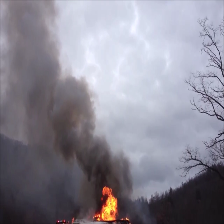

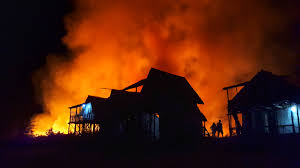

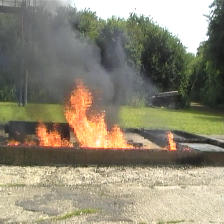

In [8]:
from IPython.display import Image, display

fire = list(data_dir.glob('Fire/*'))

for image_path in fire[:3]:
    display(Image(str(image_path)))

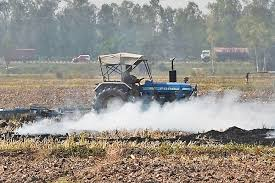

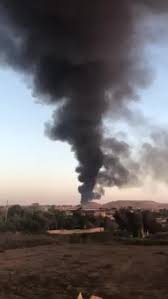

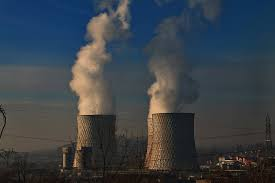

In [9]:
from IPython.display import Image, display

smoke = list(data_dir.glob('Smoke/*'))

for image_path in smoke[:3]:
    display(Image(str(image_path)))

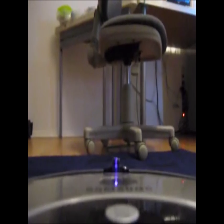

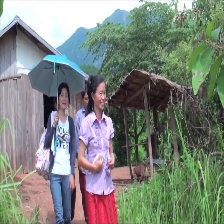

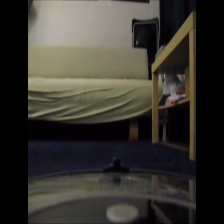

In [10]:
from IPython.display import Image, display

neutral = list(data_dir.glob('Neutral/*'))

for image_path in neutral[:3]:
    display(Image(str(image_path)))

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

IMAGE_SIZE = 124
BATCH_SIZE = 32
dataset_dir = '/data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke'

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='training')

val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='validation')

Found 4971 images belonging to 3 classes.
Found 1242 images belonging to 3 classes.


In [12]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

image_batch_train, label_batch_train = next(iter(train_generator))

image_batch_train, label_batch_train = next(iter(train_generator))


Image batch shape:  (32, 124, 124, 3)
Label batch shape:  (32, 3)


In [13]:
print (train_generator.class_indices)

{'Fire': 0, 'Neutral': 1, 'Smoke': 2}


In [14]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
print(labels)
with open('labels.txt', 'w') as f:
  f.write(labels)

Fire
Neutral
Smoke


In [15]:
!cat labels.txt

Fire
Neutral
Smoke

In [16]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0])
      plt.axis('off')

In [17]:
print(label_batch_train)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [18]:
#Definition to plot history

def plot_history(history, metric, val_metric,EPOCHS):
    
    acc = history.history[metric]
    val_acc = history.history[val_metric]

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(EPOCHS)

    fig=plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([min(plt.ylim()),1])
    plt.grid(True)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.title('Training and Validation Loss')
    plt.show()
    fig.savefig('graphs/traininghistory.pdf')


In [19]:
labelDataset=labels.split('\n')


In [20]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.applications.vgg19 import VGG19

numclasses=train_generator.num_classes

def build_model_vgg19():
    
    IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

    # Create the base model from the pre-trained model VGG19 V2
    base_model = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Conv2D(64, 3, activation='relu'))
    #model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Flatten())

    model.add(layers.Dense(32, activation='softmax'))
    model.add(layers.Dense(numclasses, activation='softmax'))

    loss = losses.categorical_crossentropy#losses.sparse_categorical_crossentropy
  #one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1] But if your Yi's are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: [1] , [2], [3]
    optimizer = optimizers.SGD(lr=0.001, momentum=0.9)#optimizers.RMSprop(lr=1e-4)#optimizers.SGD(lr=0.001) #Adam(lr=0.001)
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['acc'])

    return model

In [21]:
model_vgg19=build_model_vgg19()
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 64)          294976    
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 20,321,539
Trainable params: 297,155
Non-trainable params: 20,024,384
_________________________________________________________________


In [22]:
EPOCHS = 50
history_vgg19 = model_vgg19.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=val_generator)

Train for 156 steps, validate for 39 steps
Epoch 1/50
156/156 [==============================] - 136s 869ms/step - loss: 1.0898 - acc: 0.3726 - val_loss: 1.0912 - val_acc: 0.4130
Epoch 2/50
156/156 [==============================] - 148s 949ms/step - loss: 1.0442 - acc: 0.5039 - val_loss: 1.0862 - val_acc: 0.4316
Epoch 3/50
156/156 [==============================] - 147s 944ms/step - loss: 0.9836 - acc: 0.5876 - val_loss: 1.0713 - val_acc: 0.4428
Epoch 4/50
156/156 [==============================] - 140s 899ms/step - loss: 0.9253 - acc: 0.6488 - val_loss: 1.0453 - val_acc: 0.4734
Epoch 5/50
156/156 [==============================] - 137s 878ms/step - loss: 0.8676 - acc: 0.7007 - val_loss: 1.0121 - val_acc: 0.5048
Epoch 6/50
156/156 [==============================] - 135s 868ms/step - loss: 0.8139 - acc: 0.7483 - val_loss: 1.0437 - val_acc: 0.4847
Epoch 7/50
156/156 [==============================] - 133s 855ms/step - loss: 0.7599 - acc: 0.7878 - val_loss: 1.0094 - val_acc: 0.5016
Epoch

In [25]:
# Export the model to a SavedModel
model_vgg19.save('/data/cmpe256-01-su2020/blaze_sight/models/pranjay/model_vgg19', save_format='tf')


INFO:tensorflow:Assets written to: /data/cmpe256-01-su2020/blaze_sight/models/pranjay/model_vgg19/assets


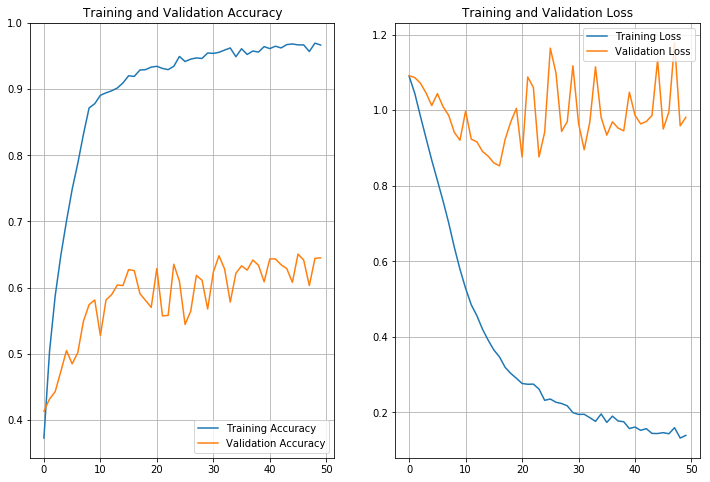

In [26]:
history= history_vgg19
plot_history(history,'acc','val_acc',EPOCHS)

In [ ]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAsYAAAHiCAYAAADrvQoIAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzsnXl8VNXZx78n+56QBAIkYUcg7BA2EcFdEKQKWq2ouNTWamtb61tetWqtdvV16+Ja3IqiorhCbRUREWXf9x2ysIUsk2WynvePM5NMwuyZZELyfD+ffGbm3nPPee69kzvPfe7vPI/SWiMIgiAIgiAIHZ2QYBsgCIIgCIIgCG0BcYwFQRAEQRAEAXGMBUEQBEEQBAEQx1gQBEEQBEEQAHGMBUEQBEEQBAEQx1gQBEEQBEEQAHGM2zRKqVClVKlSqkcg2wYTpVQ/pVSL5Ahs2rdS6j9KqRtawg6l1G+UUs/7u70gCIIdudY3r2+51guBRBzjAGK7WNn/6pRSFQ6fnf7TukNrXau1jtNaHwlk27aKUupzpdRDTpbPUkrlKqVCfelPa32p1npBAOy6WCl1qEnfv9Na/7i5fXsYUyul7m2pMQRB8A+51jcPudaDUup2pdTyQPcrNB9xjAOI7WIVp7WOA44AMxyWnfFPq5QKa30r2zSvATc6WX4j8C+tdW0r2xNMbgZOAze19sDyvRQE98i1vtnItV5os4hj3IoopR5TSr2tlHpLKWUB5iilJiilvlNKFSml8pVSzyqlwm3tw2xRw162z/+yrV+qlLIopb5VSvX2ta1t/VSl1B6lVLFS6q9KqW+UUnNd2O2NjT9SSu1TShUqpZ512DZUKfWUUqpAKXUAuNzNIXof6KqUOtdh+xRgGvC67fOVSqlNSqkSpdQRpdRv3BzvlfZ98mSH7e59p+1Y7VdK3W5bngh8DPRwiAh1sZ3LVx22v0optd12jJYppQY4rMtRSv1SKbXVdrzfUkpFurE7Hrga+AmQpZQa0WT9+bbzUayUOqqUutG2PMa2j0ds61YopSKdRUFsNk2xvffpe2nbZqgt6nNaKXVMKfU/Sql0pVS5UirJod1Y23pxDIQOg1zr5VrvzbXezf5kKKU+sV1f9yqlbnVYN14ptcF2XI4rpf5iWx6jlHrTtt9FSqk1SqlUX8cWAK21/LXAH3AIuLjJsseAKmAG5qYkGhgDjAPCgD7AHuBuW/swQAO9bJ//BZwCsoFw4G3M3bWvbbsAFmCmbd0vgWpgrot98cbGD4FEoBcm0nmxbf3dwHYgA0gBVpivncvj9grwvMPnu4B1Dp8vBAbbjt9w2z5Ot63r59g3sNK+T57ssJ2TPoCyjVEBDLOtuxg45ORcvmp7PwgotW0XDtwP7AbCbetzgO+Arrax9wC3uzkGt9i2CQGWAk85rOttG+ta27FPBUbY1r0AfAF0A0KB82z2OLM/B5ji5/cyETgO3ANEAgnAWNu6/wA/dBjnr472y5/8tbc/5Fov13o/rvXA7cByF+u+wVw7o4BRtn2fbFu3Frje9j4eGOdw/D7AfNdCbd+HuGD/f5yNfxIxbn1Waq0/1lrXaa0rtNZrtdartdY1WusDwIvAZDfbL9Jar9NaVwMLgBF+tJ0ObNJaf2hb9xTmH88pXtr4B611sdb6ELDcYaxrMY5Rjta6APijG3vBPGK71uEu+ybbMrsty7TW223HbzOw0IktznBrh+2cHNCGZRgHc5IX/QJcB3xks63a1nci5gfGztNa62O2sT/B/Xm7GViota4D3gR+4BBxnQMs1Vq/Yzsfp7TWm5TR5M0Ffqa1ztdGh7jSZo83+PK9vBI4orV+RmtdqbUu0Vqvsa17zWaj/fHxdcAbXtogCO0Juda7R671TrBF+8cC87TWVq31BsxNhF16Ug30V0qlaK0tWuvVDstTgX626/86rXWpL2MLBnGMW5+jjh+UUgOVUp/aHjeXAI9ivtyuOObwvhyI86Ntd0c7tNYac6frFC9t9Gos4LAbewG+AkqAGUqpc4CRwFsOtkxQSi1XSp1UShVj7rq9eVzk1g6l1HSl1Grbo6si4FIv+7X3Xd+fzaHNAdId2nh13myPR8/H/LgBLLa1tT8OzAT2O9k0DYhwsc4bfPleurLBbu9wZWbMXw6csF3YBaGjIdd693Toa72HMU5prcsclh12GOMWIAvYbZNLTLMtfxX4HHhHmQmMf1QiYfMLcYxbn6ZpY14AtmHu8hKAhzCPeFqSfMxjJgCUUorG/9hNaY6N+RhHyo7bFEO2C/frmOjBjcASrbVjhGMh8B6QqbVOBF720haXdiilooFFwB+ANK11EkYSYO/XU6qfPKCnQ38hmOOb64VdTbnJNu5SpdQxYB/G4b3Ztv4o0NfJdscxj26drSsDYhzsC8M85nPEl++lKxvQWpdjzs8NmPMn0WKhoyLXejfItd7tGKlKqViHZT3sY2itd2utr8PIZP4PeE8pFaW1rtJaP6K1HoSR0V2FuQ4LPiKOcfCJB4qBMqXUIOBHrTDmJ8AopdQMm5N0D9C5hWx8B/i5MhOzUoBfe7HN65ho4604PFpzsOW01tqqlBqPebTVXDsiMc7nSaBWKTUduMhh/XHMhSreTd9XKqWmKDNR5T6Mrm+1i/buuAnzYzTC4e/7mKhKJ4ye8HJl0hqFKaVSlVLDtZnF/SrwtFKqq20CykSbPbuAeKXUZbbPD2P0ce5wd84/wkxQuVuZyX0JSqmxDutfx5y7K2z2CoIg13pndORrPUCIUirK8U9rfRBYB/zedn0dgYkS/wtAKXWjUirVFq0uxjjzdUqpC5VSQ2zOeglGWlHnp10dGnGMg8+9mGigBXO3/nZLD6i1Po5xtp4ECjDRv41AZQvY+BxGw7UVM2lgkRf27QPWYC5inzZZfSfwB2Vmet+PuVA1yw6tdRHwC4wM4DQwG/ODYl+/DRO5OGSb7dulib3bMcfnOcwF93LgSh/0vQAopc7DPEb7u02jdkxrfcxm1yHg+7aL5gzMxf40sAEYauviF8BOYL1t3e8BpbUuBH6K+eHJta1zfNznDJfnXGtdDFwCzML8kOyhsfZvBWaizmqttcvHtoLQwZBr/Zn2dchrvQOTMJP/HP/AnLP+mOv0IuB+rfVy27ppwE7bcXkC87tQhfnteB/jFG/HyCre9NOuDo0yTzOEjoxt4lYeMFtr/XWw7RHOfpRSK4D5WutXg22LIAgGudYLgmckYtxBUUpdrpRKss0I/g3mscsaD5sJgkdsjz2HAO8G2xZB6OjItV4QfMOjY6yUmq+UOqGU2uZivVImCfg+pdQWpdSowJsptADnAQcwj4MuA67SWrt6vCYIXqGUWgD8G7inyaxqQRCCg1zrBcEHPEoplFLnYxJav661HuJk/TSMfnEaJpffM1rrcU3bCYIgCIIgCEJbxmPEWGu9AiNSd8VMjNOstdbfAUlKqW6BMlAQBEEQBEEQWoNAaIzTaZxMu2mya0EQBEEQBEFo87RqVRSl1B3AHQDR0dGjMzMzPWxxJnV1dYSEtN85g+19/6D972N73z9o//voaf/27NlzSmvtLh9suyM1NVX36tXL5+3KysqIjY313PAspr3vY3vfP2j/+yj7B+vXr/fquh0IxziXxlVmXFaB0Vq/iKm9TnZ2tl63bp3Pgy1fvpwpU6b4buVZQnvfP2j/+9je9w/a/z562j+llKdyt+2OXr16Idds57T3fWzv+wftfx9l/7y/bgci5PMRcJMtO8V4oFhrnR+AfgVBEARBEASh1fAYMVZKvQVMwZRJzMGhnKzW+nlgCSYjxT6gHFO6UBAEQRAEQRDOKjw6xlrr6z2s18BdAbNIEARBEARBEIJAq06+EwRBEARBaOtUV1eTk5OD1WoNtikBITExkZ07dwbbjBbDcf+ioqLIyMggPDzcr77EMRYEQRAEQXAgJyeH+Ph4evXqhVIq2OY0G4vFQnx8fLDNaDHs+6e1pqCggJycHHr37u1XX+0335IgCIIgCIIfWK1WUlJS2oVT3JFQSpGSktKsSL84xoIgCO0IpdR8pdQJpdQ2F+tvUEptUUptVUqtUkoNb20bBeFsQJzis5PmnjdxjAVBENoXrwKXu1l/EJistR4K/A5bbnlBENoOBQUFjBgxghEjRtC1a1fS09PrP1dVVXnVxy233MLu3bvdtvn73//OggULAmEy5513Hps2bQpIX8FENMaCIAjtCK31CqVULzfrVzl8/A5TlEkQhDZESkpKvZP5yCOPEBcXx69+9atGbbTWaK1dVul85ZVXPI5z112SVKwpEjEWBEHouNwGLA22EYIgeMe+ffvIysrihhtuYPDgweTn53PHHXeQnZ3N4MGDefTRR+vb2iO4NTU1ZGZmMm/ePIYPH86ECRM4ceIEAA8++CBPP/10fft58+YxduxYBgwYwKpV5h66rKyMWbNmkZWVxezZs8nOzvY6MlxRUcHNN9/M0KFDGTVqFCtWrABg69atjBkzhhEjRjBs2DAOHDiAxWJh6tSpDB8+nCFDhrBo0aJAHjqvkYixIAhCB0QpdQHGMT7PTZs7gDsA0tLSWL58uc/jlJaW+rXd2UR738f2vn9w5j4mJiZisVgA+NN/9rPreGlAxxuYFsevL+3rVdvKykrCw8OxWCyUlpaya9cunnvuOUaNGgXAAw88QHJyMjU1NVxxxRVMnTqVgQMHUltbS1lZGRaLheLiYsaMGcMDDzzA//7v//Lcc8/xy1/+ksrKSqxWKxaLhdraWiorK/niiy9YsmQJDz30EIsXL+bJJ58kOTmZ1atXs3XrViZNmlTfryOO49l56qmnCAkJYdWqVezcuZPZs2ezceNGnnnmGe666y5mzZpFZWUlWmvee+890tPTeeeddwAoLi4+YwxX1NbWNmprtVr9/s6KYywIgtDBUEoNA14GpmqtC1y101q/iE2DnJ2dradMmeLzWMuXL8ef7c4m2vs+tvf9gzP3cefOnfXpzcIjwgkNDQ3oeOER4V6nT4uMjCQyMpL4+Hji4uLo27cvkydPrl//+uuv889//pOamhry8vI4fPgwY8aMITQ0lNjYWOLj44mOjmbWrFkATJgwga+//pr4+HgiIyOJiooiPj6e0NBQrrvuOuLj4znvvPN4+OGHiY+PZ+3atfz6178mPj6ec889l8GDB9f364jjeHbWrl3LfffdR3x8PGPHjiU9PZ3jx48zefJk/vznP3PixAmuvvpq+vXrx7hx4/jtb3/L448/zowZM5g4caLXx7NpOrqoqChGjhzp9faOiGMsCILQgVBK9QDeB27UWu8Jtj2C0NZ5eMbgYJvQiNjY2Pr3e/fu5ZlnnmHNmjUkJSUxZ84cp6nKIiIi6t+HhoZSU1PjtO/IyEiPbQLBjTfeyIQJE/j000+5/PLLmT9/Pueffz7r1q1jyZIlzJs3j6lTp3L//fe3mA2uEI2xIAhCO0Ip9RbwLTBAKZWjlLpNKfVjpdSPbU0eAlKAfyilNiml1gXNWEEQmkVJSQnx8fEkJCSQn5/PZ599FvAxJk6cWC9v2Lp1Kzt27PB620mTJtVnvdi5cyf5+fn069ePAwcO0K9fP+655x6mT5/Oli1byM3NJS4ujhtvvJF7772XDRs2BHxfvEEixoIgCO0IrfX1HtbfDtzeSuYIgtCCjBo1iqysLAYOHEjPnj19kh94y09/+lNuuukmsrKy6v8SExOdtr3sssvqSzFPmjSJ+fPn86Mf/YihQ4cSHh7O66+/TkREBG+++SZvvfUW4eHhdO/enUceeYRVq1Yxb948QkJCiIiI4Pnnnw/4vniDOMaCIAiCIAhtlEceeaT+fb9+/RplhFBK8cYbbzjdbuXKlfXvjx49Wv/+uuuu47rrrgPgsccec9q+a9eu7Nu3DzB63TfffJOoqCj27t3LpZdeSmZmptvxHHn99dfPWPbggw/y4IMPNlo2bdo0pk2b5rSP1kQcY0EQBEEQBMEppaWlXHTRRdTU1KC15oUXXiAsrP26j+13zwRBEGx8tDmP/KIKpg7pRo+UmGCbIwiCcNaQlJTE+vXrW6bzmio4uQtS+0F427g2i2MsCEKrU1BayYFTZeQVVZBbVEFuYQV5RRWUWGvolRJL/7Q4zkmLo3+XeNKTogkJUX6PtSWniF+8vYnaOs0flu5iSHoCU4d044qh3eiVGuu5A0EQBKFlqLGCroVqqzjGgiB0PEora/jrF3uZ/81Bqmt1/fJOMeF0T4omLjKMlftO8t6GnPp1UeEhpMZFopr4xuGhIfz68oFcNriry/Gs1bXc+85mUuMieGXuWL7Zd4pPt+bzl89285fPdjOoWwL3TxvIpP6dA76vgiAIggfqbCnh6mqDa4cD4hgLguCU6to6rNW1xEeFe2y76WgR3+w7xeiencju2Ymw0MaZILXWfLAplz8s2cUJSyXXjM5g+vDupCdF0z0pipiIxpei4opq9p2wsPd4KXuOl1JUXnXGmNvyivnZWxt5+0cTGJGZ5NSupz/fy94Tpbx6yxiyuieQ1T2BH57fh9yiCv697RhLtuYTHR7YxP2CIAiCl9gdY91yOZN9RRxjQRDOoLiimlteWcOWnGLOP6czM0d055KstEYObGVNLZ9uyee1bw+z+WhR/fKkmHAuHNCFi7PSOP+czhw6VcYjH21n3eFChmck8sKNoxnZo5Pb8ROjwxndM5nRPZNdtikoreR7//iG219bx4d3TyQ9KbrR+g1HCnlxxX6uG5PJlAFdGq1LT4rmtvN6c9t5vX05LIIgCEIgaYMRYynwIQhtBK01W3OKeejDbdy1YAOVNd5dKLTWnhv5QGFZFTe8/B1bc4uZPTqDXfkl3LNwE6N/9zn3LNzIZ9uP8d6eKs79wzJ++c5mSq3VPDpzMGvuv4jnbhjFhQO7sGz3CX6yYAOjHv0vM/62koOnyvjTrKEs/slEj06xt6TERTL/5jFUVtdy26trsVir69dZq2v51bub6ZoQxQNXDArIeIIgtALFubD6BQjwde1s44ILLjijWMfTTz/NnXfe6Xa7uLg4APLy8pg9e7bTNlOmTGHdOvd1fZ5++mnKy8vrP0+bNo2ioiI3W3jHI488whNPPNGwoA06xhIxFoQgc6q0kg825vLuuhx2H7cQERZCVU0dfbvE8ctLznG77cYjhfz4X+u577KBzB6dERBb5ry8mgOnynjhxtFcODCNujrN2kOn+WBTHku25vPhpjwUcNGgNOae24uJ/VJQNgHw1KHdmDq0GzW1daw/XMjnO48TGRbKD8/vQ2K0Z0mGr/RPi+cfc0Yx95W1/Oytjbx0UzZhoSE88dluDpws41+3jfNKCiIIQhth67vw+cPQZwp0HhBsa4LG9ddfz8KFC7nsssvqly1cuJA///nPXm3fvXt3Fi1a5Pf4Tz/9NHPmzCEmxkyIW7Jkid99uaXeMW47UgqJGAtCEKit0yzbdZwfvr6O8b//gsc+3Ul0RCiPfW8Iax+4mKtGpvPc8n3sPmZx2UdpZQ33LNzE8ZJK7lu0mcUbc1y29YbjJVa+/8K3HCooY/7NY7hwYBoAISGKcX1S+MPVQ1n7wMUsuH0cfz4/mpdvzua8/qn1TrEjYaEhjOuTwgNXZPGrywa0iFNsZ1L/zjw6czBf7j7JY5/uZO2h0/zzm4PMGd+D8/qntti4giC0ABWF5vXo6uDaEWRmz57Np59+SlWVmV9x6NAh8vLymDRpUn1e4VGjRjF06FA+/PDDM7Y/dOgQQ4YMAaCiooK5c+cyaNAgrrrqKioqKurb3XnnnWRnZzN48GAefvhhAJ599lny8vK44IILuOCCCwDo1asXp06dAuDJJ59kyJAhDBkyhKeffrp+vEGDBvHDH/6QwYMHc+mllzYaxyW1xiF+8h8vn9FnWVkZV1xxBcOHD2fIkCG8/fbbAMybN4+srCyGDRvGr371K5+PrSckYiwIrUh+cQXvrM3h7bVHyCu2khoXyW2TenPN6Az6dYmvb/eb6Vl8teckv35vC+/deS6hTtKV/faj7eQUlvP6rWN5/qv93PvOZkKUYuaIdJdjP/P5XqzVtQzunmgmo3VLoFNsBLlFFfzgpe84ZanktVvGMq5PitM+IsJCmNgvleU5beue+oZxPTlwsox/rjzI+xtyyOgUzf9OFQmFIJx1WG2P64+uhlE3BdcWO0vnwbGtge2z61CY+keXq5OTkxk7dixLly5l5syZLFy4kGuvvRalFFFRUSxevJiEhAROnTrF+PHjufLKK50GKQCee+45YmJi2LlzJ1u2bGHUqFH16x5//HGSk5Opra3loosuYsuWLfzsZz/jySef5MsvvyQ1tXFwYf369bzyyiusXr0arTXjxo1j8uTJdOrUib179/LWW2/x0ksvce211/Lee+8xZ84c98ehrob1W3bwypvvsXrdxkZ9HjhwgO7du/Ppp58CUFxcTEFBAYsXL2bXrl0opQIi72iKOMaC0ILU1mkOFZSxLbeYjzfns2zXceo0TOqfykMzsrhoUBrhoWc6mcmxETw8I4t7Fm7itVWHuLXJJLGlW/N5d30Od13Ql/PP6cyYXsnc8uoafvH2JkKUYsbw7vVta2rreHXVIZ767x5q6jSdYiL4YFNe/fruiVFU1dZRWV3H67eNY3TPwGiAW5v7pw3icEEZX+w6wYs3ZRMbKZc3QTjrqLA7xmuCa0cbwC6nsDvG//znPwEzr+T+++9nxYoVhISEkJuby/Hjx+na1XnqyhUrVnD77bcDMGzYMIYNG1a/7p133uHFF1+kpqaG/Px8duzY0Wh9U1auXMlVV11FbKzJAX/11Vfz9ddfc+WVV9K7d29GjBgBwOjRozl06JDnnayrYeWaTVw19cIz+rz88su59957+fWvf8306dOZNGkSNTU1REVFcdtttzF9+nSmT5/ueQwfkV8OQfCDU6WV/O6THZRV1pIUE05SdDhJMeEkxkSw90g1/128lR35JezKt1BRbSYVpMZF8uPJfbluTA+vqq9dObw7izfm8sR/dnNJVhqZyWabY8VW5r2/lWEZifz8YqNBjo4IZf7cMcydv5afv72J0BDFtKHdWH+4kAcWb2XXMQsXDOjMozOHkJkcQ0FpJTvzLezIL2Z7XgkFpVX8+vKBDM1IbLmD1sKEhij+ccNocgrL6dM5LtjmCILgD/aI8ak9UH4aYlxnpmk13ER2W5KZM2fyi1/8gg0bNlBeXs7o0aMBWLBgASdPnmT9+vWEh4fTq1cvrFarz/0fPHiQJ554grVr19KpUyfmzp3rVz92IiMj69+HhoZ6llJobYp7AOi6M1afc845bNiwgSVLlvDggw9y0UUX8dBDD7FmzRq++OILFi1axN/+9jeWLVvmt83OEMdYEHzkeImVG15ezdHTxgHbkVdMUUU15VUNs2rjo/LI6pbA9WN71EsW+qfFOY0Ou0IpxeNXDeWSJ7/igQ+28dotY9Aa7n13E1U1dTz9/RGN+ouJCGP+LWOYO38NP3trIx9szOU/O47TLTGK5+eM5rLBafWP2lLiIjmvf2S70+BGhIWIUywIZzMVhRCVCNZiEzUecHmwLQoacXFxXHDBBdx6661cf/319cuLi4vp0qUL4eHhfPnllxw+fNhtP+effz7vvvsu06dPZ9u2bWzZsgWAkpISYmNjSUxM5Pjx4yxdupQpU6YAEB8fj8ViOUNKMWnSJObOncu8efPQWrN48WLeeOMN/3bQNuFu0vgxzP35A8wrLUUrVd9nXl4eycnJzJkzh6SkJF5++WVKS0spLy9n2rRpTJw4kT59+vg3thvEMRYEH8gtquCGl77jpKWS124dy3gHLW5lTS3FFdV8vXIVV19+gUu9ly+kJ0XzP5cN4JGPd/DBplwKSqv4Zl8Bv79qqFMHMC4yjFduGcPN89fwxa4T3HF+H+65qL/ICgRBODuoKIJek2DPv43OuAM7xmDkFFdddRULFy6sX3bDDTcwY8YMhg4dSnZ2NgMHDnTbx5133smcOXMYNGgQgwYNqo88Dx8+nJEjRzJw4EAyMzOZOHFi/TZ33HEHl19+Od27d+fLL7+sXz5q1Cjmzp3L2LFjAbj99tsZOXKkd7IJG4899phtgp2G2hpytq5k7jVXMnb8OEDV9/nZZ59x3333ERISQnh4OM899xwWi4WZM2ditVrRWvPkk096Pa63qEDnQPWW7Oxs7SmPnjOWL19ef0fTHmnv+wcts49aa3YdszCwa3xAHFJnHCko5/qXvqOkoppXbx3rUosb6P2rrdNc8/wq9p8so6KqlskDOvPijaPd7mdlTS2FZdV0TYwKmB2OtPfvqaf9U0qt11pnt55FwUeu2a5p7/vYqvv3xx4w9FrI2wBh0XDLp60ybNN93LlzJ4MGtZ8JvBaLhfj4eM8NW5NKCxTsg5hUKD8FnQdCeLTn7ZzQdP+cnT9vr9tta2q5IPjJiysOMPWZr3nwg23U1gX+Zm//yVKufeFbyqpqePOH41t1glpoiOKPs4ZRXlVDYkw4f5o1zKPzHxkW2mJOsSAIQotQVwfWEojuBJnjIHc91FZ73k44O7HnLg6zaZPbSJEPeb4qnPWctFTy12X76JoQxYLVRzhpqeTZ60cSFR7qcduKqlq25RWz+WgRG48WcbigjE4xEXSOjzR/cZEkRIXz5892o7XmrR+OZ1C3hFbYq8ackxbPG7eNIzUuguTYiFYfXxAEocWpLAY0RCdBWhZ89w+TJi19lMdNhbMQcYwFoWX4v//sxlpdy4d3T2Tl3lM88vF25ry8mpdvziYp5kwnctexEhauOcqag6fZfdxSH2FOT4qmb5c4iiuqOXCyjJOWSqpqzUzZLvGRvHnH+Ea5hlub8S5yCwuCILQL7KnaopIgw2hYObpaHOP2iq24B6E2x1i3jep34hgLZzXbcot5e91Rbp3Ym76d4+jbOY7O8ZH8fOEmZj//La/dOpb0pGhqauv4z47jvLbqEKsPniYyLISxvZP5yaC+DM9IYnhmEp3jIxv1rbWmpKKGk6VWuiZGEycT2ARBEFoOe9W76CRITIfETOMYj78zKOZorVtszkq7QNdBSR7EdYFQP55k1tWACoVQ229rgCLGzZ07J7/0wlkfGh0dAAAgAElEQVSL1prffbKDpOhwfnZh//rl04Z2o1NMBHe8sY6r//EN12Znsmh9DvnFVltFtIF8f0ym02iyI0opEmPCSYxpuXLGgiAIgg2rQ8QYIHMsHPkuKKZERUVRUFBASkqKOMeuqLZC2UkIi4JYP1J/1tVASJhxjiEgjrHWmoKCAqKi/J9jI46xcNby723HWH3wNL/73pAznNcJfVN498cTuHn+Gv66bB/n9Uvlt1cO5qJBaU7LKwuCIAhBxi6liLZNbs4cB9veg+IcSMxoVVMyMjLIycnh5MmTrTpuS2G1WpvlLDqlusI4xlGVEOXHcSo9AWg4raD4FERUQLR/JZ4d9y8qKoqMDP+/L+IYC2cl1upaHl+ykwFp8Vw/JtNpm4FdE1h6z/mUVFTTKzW2lS0UBEEQfMIeMY62R4zHmdejq1vdMQ4PD6d3796tOmZLsnz5ckaOHBnYTtfNh89+AePu9K864D9uheQ+cN0CeOY6yBgDs172y5RA7p+kaxPOSuZ/c5CcwgoempFFmJtqcsmxEeIUC4IgnA1UNJFSpA2B8BhTAU9oe1iOmdfyU/5tX3aqQYIRldRw/oOMOMbCWceJEit/X7aPS7LSmNivfZU0FgRB6LBUFJpJXPYiD6FhkD46aDpjwQOWfPNa5odjXFcH5QWmuAcY+Yx98mWQEcdYaHHq6jS5RRV8s+8Ub605wu7TtdT5WYSjtk7z+yU7qaqt4/5p7acqkSAIQofHWmQcJMfJbpnjTC7jqrLm9//uXFjxl+b3IxiaEzG2FoGuhRhbGtLopAYpTZARjbEQcKzVtby/IZdlu05wqKCMI6fLqaqpa9Rmwb7lzBqVwazR6WR0ivGq3/WHC3nko+1szS3mJ1P60lskEoIgCO2HiqIGGYWdzHHGgcrdAL0nNa///V+aqOT59zWvn6YUHoIF18Cc9yHJ+ZyXdkl9xLjA923Lbds0klK0jYixOMZCwDhpqeSNbw/xr9VHOF1WRe/UWM5Ji+OigV3omRJLr9QYMpJi+Ndnq9heHs3TX+zhqc/3cG7fFGaNymBC3xS6JUadkRrnhMXKH5fu4v0NuaQlRPLMdSO4cnj34OykIAiC0DJYixom3tnJyDavR1c3zzGurjD9W47734crcjfAqT2Qt6GDOcYOEWOtG0f6PWGXX9RHjDuZGyNf+2kBxDEW/EZrTUV1LQdPlfHaqkN8sDGP6ro6LhqYxg8n9WZs72Sn+R/P7R7G/VPGk1NYzvsbclm0Pod7390MQOf4SIZnJDEiM5ERmZ3YmV/CM1/spbKmljun9OXuC/oRK4U2BEEQ2h8VRRDfrfGymGRIHdD8CXh2J670WPP6cdd3cW7g+26r1FabVG0RcVBVav4ifagMa5df2CPG0UnmyYCv/bQA4mEIXqG15unP9/Lt/gKKKqooLK+muLy6vmRyVHgI147J4NaJvenTOc6rPjM6xfCzi/pz9wX92JZXzKajRfV/n+9suKu/YEBnHpoxWKQTgiAI7ZmKIujiZO5Ij3Gw82MzYSvEz6lRpbbflIpCqKmEsEj37X3BkmdeSzqQY2w/nl2yIGeNiQD74tDWR4wdpBRgzo84xsLZwFP/3cOzy/YxIjOJvp3jSIoJJzE6gqSYcJJjI7hkUBqdYv0oCQmEhCiGZSQxLCOJmyaYZcUV1WzJKSIyLJSxvZMDuCeCIAhCm8Q++a4pmeNgw+tQsBc6D/Cvb7seFoxTl9TDv36c9m2LGHckx9i+z12HGMe4vACSfcj7fEbE2HbeK4oCe278QBxjwSNvrTnCs8v28f3sTP44a2irlMdMjA5nUv/OLT6OIAiC0Aaoq4XKkjMn30HjQh9+O8YOEgpLCznGHUlKYb/RSBtiXn1N2VZWABHxDZF7u7a8DWSmkHRtgluW7TrOgx9sY8qAzjx21RCpGS8IgiAEHmuxeW06+Q4gpZ+JKB5Z7X//jSLGAdYZ2/suyQtsv22Z+ojxUPPqa8q28gKITWn4XB8xDn5mCnGMBZdsySnirgUbGdQtnr//YBThbirMCYIgCILf2B0iZxFjpUxksmCf//1bjpkqevb3gUJrKLE5xpZ8E/nuCFjyISSsIYLva8S4/FSDvhgcNMYSMRbaKEcKyrn11bWkxEUwf+4YyQQhCILvWI4TWlMebCuEswG7Q+QsYgwQl9Yw4csfLPlmYp8KaV4/Tam0QHUZdOptsioEsu+2jOUYxHWFyAQIjfQ9YuxYDhoaznsbiBiLt9OB2Zlfwu2vraO2TtM9KYruSdGkJ0XTPSmaV1cdoqZO89qtY+kSHxVsUwVBOAvJ/eA3jN//Ppy6DIZcDedcDhGSXUZwgtXmEDmbfAcNjrG/eW4tx010szg3sBFje18Z2VB40PSf0AHy7JfkQXxXcy5iU30v8lFe0CDDAJP2LSSsTWiMxTHuoBSXV/OjN9ZTXVvH5HM6k1tUwbbcYv6z/ThVtXVEhYew4PZx9PUy9ZogCEJTloZfQnhtETceXUPIrk8gLBrOsTvJUyHMv0w2QpDRGj64E4ZfB32mBKZPe8TYmZQCID4NqstNhDYqwff+Lcegz2TjzAUyqmvXF6ePhq3v2jJTjAlc/20VyzFI6Wvex6T4FjHW2kSMYxw0xkrZqt+JYywEgbo6zc/f3kh+cQUL75jA6J6dGq0rKKsiIjSExJjwIFopCMLZzojxFzF7UwxJFz/BzE5HYNv7sOND2PEB9JoEP3hbIshnI9Zi2PwWHPkO7l4LoQH4rbB6klJ0Na+lx313jKvKoLLYOMXxXQObVq3eMbZV6OsoKdss+dDrPPM+NtU3jXFVKdRWNpZSgK36XfClFKIx7oA8u2wvX+4+yUPTsxo5xWByCneOjxSnWBCEZjOqRyeSIhVLtp0wP6LTn4R7d8OMZ+HwN/Dm943TIpxdVJw2r4UHYf2rAerTi4gx+Bfttcsd4rsZSUYgy0LbHeMug8wTkY6QmcJeXjvedrMSk+pbxLhpcQ870UltQkohjnEHY9mu4zz9+V5mjcpgzviewTZHEIR2TEiIYnRaKMt3n6SsssYsDA2D0TfDVS8a53jBteIcn23Yo3oRcfDVn4y8IRB9hkVBuIs5LXE2x9gffXC9Y2yLGJedhNoa/+x01ndkAkTGQWI6FOcEpt+2jOONBviuMS4vaNjOkTYipRDHuANxuKCMny/cxODuCTwuOYkFQWgFxnYNo7KmjmW7TjReMewa4xwfWQULrhHn+GzC7hhfcL9xMr/9e/P7dFX1zk5ccyLGtqiuPWKMNnYHAkt+Q+Q0oXvHkFI43miA0QpXl5lIsje4jBiLlEJoRSqqavnRG+tRSvH8nNFEhYcG2yRBEDoA/TuFkBoXydJt+WeuHHYNXP0SHPnWOMeVpa1voOA79qhev4shayas+iuUnnC/jTd9upJRgHGaQiMDEzGGwBX5KHF0jDM6hpTC8UYDGiK/3uqM68tBpzReLlIKobWoqqnjl+9sYvdxC89eP5LM5JhgmyQIQgchRCkuH5LGl7tOUl7l5PH10NmNneNqa+sbKfhGhUNqtQsfMpHCr/7cvD6txa4n3oHJWhCX5p8DXnrMyDSikhom8QVKZ2w5BvG29GyJ6cZpDJRMo61yRsTY5hh7qzN2FTGOSjLfgyAXSRHHuJ1TWlnDra+uZem2YzwwbRCTz+kcbJMEQehgTBvajYrqWpbvdvH4ut45XgXf/q11jRN8x7FKXWo/oxlf/woU7G9Gnx4ixmAm4PkT6bUcM061Ug6T+AIQMdb6TCmFrmv/RT4s+SZ6b5e+1EeMvdQZlxeYG5WmGWns/dnLgwcJcYzbMScsVr7/wrd8e6CAv8wexu2T+gTbJEEQOiBjeyWTEhvBkq1O5BR2hs6GgdPh6ycbSuwKbZOKQjPxzp6HevI8CI2AZY/536e1yH3EGPzPKGE55vDYv4ttWQCc1/LTUFfd0HdChnlt7zpjy7GG4h7ge8S4vMDokpvOc7Kf/yDLKbxyjJVSlyuldiul9iml5jlZ31Mp9YVSaotSarlSKiPwpgq+cOBkKbOeW8WBk2W8fHM212RnBtskQRA6KGGhIVw6uCvLdp3AWu3mMemljxlH44vftp5xgu9UFEJ0csPn+DSYcDdsfx9yNzSjTzeT78AmpfAnYuwQ1Q2LME5ZICLGFpue2DFiDB3AMc5vuBmABq2wtxrjpsU97NjPf5An4Hl0jJVSocDfgalAFnC9UiqrSbMngNe11sOAR4E/BNpQwXs2Hilk9vPfUl5Zy8I7xnPBgC7BNkkQhA7OtKFdKa9yI6cASO4NE+4yxSNy1reecYJvVBSeGd0996fG2fn8YSMx8IXaalP0waOUoqsZu6bSt/4dI8ZgdMaBiBjbtbYJDhpjMGWh2zP2iLGdqCRTztnriPGpM1O12fuBoKds8yZiPBbYp7U+oLWuAhYCM5u0yQKW2d5/6WS90ApYq2t55ZuD/OCl1cRFhvHenecyPNPDhUYQBKEVGN8nhU4x4c6zUzgy6V4TGVz6P1BX1zrGCb7hLLoblQDn/gwOroCiI771Z9eUeiOlAN8m4FVajNPt6Mj5q1VuSn12BlvfUUkQHtP+M1M0vdFQytwU+RQxduIYn0VSinTgqMPnHNsyRzYDV9veXwXEK6WcxMmFlqCiqpaXvz7ApD9/yW8/3sHIHkm8d+e59EqVUquCILQNwkNDuDSrK1/s9CCniIyHix6G3HWw9d3WM1DwHleyhy6DzKuvmSM8Vb2z408uY3tk+IyIcSAc42ON7VIKEtKhpB0X+ai0QJWl8Y0G2Krf+TD5zlnEuI1IKcIC1M+vgL8ppeYCK4Bc4Iwrn1LqDuAOgLS0NJYvX+7zQKWlpX5td7bgy/5V1miWHa1h6cFqSqo0g5JDuG1sFAOTrWxf/23LGtoM5Bye/bT3fWzv+xcspg7tytvrjvL13lNckpXmuuHw62HtS+ax/MArTFUxoe3gyjH2dRKWHXuE0FPEON6P6ndNo7r296XHzROJkGbkICjJM5HSsMiGZQnd23fEuGnVOzuxXkaMq60mgu9MY9xGpBTeOMa5gOPMrQzbsnq01nnYIsZKqThgltb6jD3TWr8IvAiQnZ2tp0yZ4rPBy5cvx5/tzhY87Z/WmvWHC/lwUx6fbMmjsLya8/ql8rOL+jO2d7LL7doSHf0ctgfa+z629/0LFhP7pZIYHc7SrfnuHeOQELj8TzD/UvjmabjwwdYzUnCP1q4dY/skLG8jh3Yc8yK7w56D2KeIcZOcu/b3dTVQcdp55NKXvu05jO0kZsD+L/3vs61jv9FIaOIYx6RA/hbP29cX93By3MOjTBq3syBivBbor5TqjXGIrwN+4NhAKZUKnNZa1wH/C8wPtKEdnT3HLXywMZePNueRU1hBVHgIFw9KY+65vcjudXY4xIIgdGzCQ0O4JCuNz7Yfo7KmlsgwNxU4e4yDIbNNVbWRN0Knnq1nqOCaSotxKt1FjL3VmtrxVkoR2xlQPjrGTiLGcQ6R52Y5xvlnSgoS0o1+ubYGQgP1UN5LrCWweykMu/bMVGiBwlXEOCbVuycFrop72Inu1PY1xlrrGuBu4DNgJ/CO1nq7UupRpdSVtmZTgN1KqT1AGvB4C9nboaiureOjzXnM/NtKLn1qBS+sOEDfznE8ee1w1j14CX/7wShxigVBOKuYNrQrFmsN3+zz4kf0kt8CCj5/xPsBqsr8NU3wBnfR3YhYU/ihpaQUoWHGkfVJSnHMTIiLTGhYFqiy0E2zM4BDkY8AlZz2hS1vw+I7IG9jy43h7EYDzHmxFpsMI+5wFzEGc3N0Fkgp0FovAZY0WfaQw/tFwKLAmtZxKbFW8/aao7zyzUHyiq30SY3l4RlZzBjendS4SM8dCIIgtFEm9kslLjKM/+44wYUD3cgpwDyWHn8nrHzKyClS+rpvv3khfHwP/PgbU5FNCDzuHGOljMPjbQW0+j69jBiDkVP4GjF2LEYBDhHjZqRsq62BshNnRk4TbWUcinMb3rcWp/aa18PfQPqolhnDcswUd4mMb7w8xkFG09RpdqT8dOP2TYnuFHTHWCrftSEs1mre2lnJuX9YxuNLdtIjJYaXb8rm819O5paJvcUpFgThrCcyLJTsXp1YfdBL52ncjyE0HL77h/t2dbXw1Z+gxgqrn2++oYJzPOmBY1J81xhbi0xU115Jzx3xab5HjJs6r4GIGJedMJHhplrbYBb5KNhnXg9903JjOJOPgENZaA9PC+qlFK4c46S2L6UQWo8HFm/jP4druGhQFz6++zwW3jGBi7PSCAlpIa2QIAhCEBjfJ4UDJ8s4YbF6bhyfZjSTGxc0RJucseMDOH0AOvWGTW8GPerUbvHkGMd6qTVt2qeniXd24rr6lg6u1IncITwaIhObFzGulxQ0dYxt2WyD4Rif3m9ej6xquRzgzm40wPuMJOWnQIW6fjoQlRT0yXfiGLcRlm7N56PNeXyvXzjPXDeSoRmJwTZJEAShRRhny6Cz5qAbR9eRCXdDTQWs/afz9VrD109B6jlwzStQXQYb3wiQtUIjPEaMU/2bfOeNjAIgrouJ1nrj+Gnt2pFrbpEPZ9kuAKISITy29VO21VSZwipJPY3W98T2lhknEBHjmBTXafJESiEAFJRW8uAH2xiansgVfcKDbY4gCEKLMiQ9kZiIUFYf8NIx7jII+l0Ma140eVCbsve/cHwrTPw5dB8JPSfC6heNDlQILC0lpfA08c6OPdWaN2NUlkB1eYOm2JG4tOZFjO2Ob1OnWylTGrq4lYt8FB4y0o5RN5rPLSGnqL/RcOIY10eMPZwXV8U97EQnmRvbmir/7Wwm4hgHGa01D36wDYu1hieuGU6YyCYEQWjnhIeGMLqnDzpjgHN/aiKFzqrhrXwSEjJg6DXm8/g7ofgI7P40MAYLDVQUGj1weJTz9bEppoCDsxsYl336EjG2V7/zItrrKrUY2Ip8NDNirEJtKeSakJDe+hFju764zwWQ2AMOrwz8GNYio+F3KqVIBpT3EWNX2G+4gqgzFsc4yHyyJZ+l247x80v6M6BrvOcNBEEQ2gHj+6Sw53gpBaWV3m3QezKkDYVv/2YiV3YOr4Ij38LEnzVM3howDZJ6wHcyCS/gVBS51wN7Gzl0xNeIMXiXmcJVajFoiBg7fpd8wXLM9BHiJBd3Qnrra4zt+uLkPtBrovm/8HffXOFKPgLmOER38k5j7C5i3Aaq34ljHEROWKz85sNtjMhM4o5JfYJtjiAIQqsxvo+POmOl4Ny74eQu2Pd5w/KvnzTO2MgbG5aFhJpsFkdWtWxO146Ip4lysX6UhfZp8l0X8+qNDMJTxLimwuhx/cGV1haMlMJyzHNO30BSsN8cw5hkIyUqL4CTuwM7hqsJh3ZivdCXl51yXdwDGm6QJGLc8dBa88DibZRX1RoJRaicCkEQOg5D05OICg9htbeOMcDgq82P8qq/ms/5W2Dff410IiKmcduRc0y+VYkaB5aK095FjL2dgFdTZXTAXkspfEi1Vu8YO9MY+1FeulHf+a4dxITugPYtrVxzKdgHKbbc3b0mmtdAyylK3ETgwVb9zs2Tgtpq4/C61RjbvltBzEwh3liQ+GBTLv/dcZz7Lh1Avy5xwTZHEAShVYkIMzrj7w748Mg9LMJEgg9+ZZzilU9CRDyMuf3MtlGJMOIG2PZe6zoo7Z2KQveyB8dCD97gbdU7OxG2KnbeRowj4s8sRgENzrK/3w1L/pk5jO0k2Ap7tKac4vQBSLYVwOnU2zjth1cFdgx7xDjOhWMcm+L+hshTcQ8QKUVH5T/bj/GbD7aT3bMTt57XO9jmCIIgBIXxvVPYdcxCYZkPM9BHzzWR4H//L+z4EMbc5tqpGvcjk8Fg3fyA2Cvgg5TCS8fYl6p3duLSvNcYu4pu2qO9/kSMq63mOLjqu7WLfFSVm7HsEWOljJzi0DeB1RlbjpkbzqZPZ+zEeMhhXe6huAc0/C9LxLhjUF1bx2Of7OCON9bTOzWWZ68fSahkoRAEoYMyro/5gVxzyAc5RXSS0RMfXgmhETDhLtdtU/rCOZeZ/Me+ZEkQnKO1Z8c4Kslka/BWSuFrxBh8cIxdpBaz92Fv4yulbrTLYDTGYMpCtwanD5jXFIe5Sr0mGjvt6wKBO/kI2Iq7nDZVKJ1hv1nyZvKdaIzbP7lFFVz7wre8vPIgN03oyaI7J9A9KTrYZgmCIASN4ZmJRIaFeJ/P2M74OyEkzDjI9slY7tqWn4Jti/w3VDBUl0NtlXvHOCTETADzdvKdp7zIzvC2LLS7iHFkvEk750/E2JPWNjLBPNVorZRt9lRt9ogxQM/zzOuhAOqM3d1ogE1frl1He+vLQbtxjEPDjPxFpBTtm2W7jnPFs1+z93gpf/vBSB6dOYTIMCcpXgRBEAKAUmq+UuqEUmqbi/VKKfWsUmqfUmqLUmpUa9sIEBkWysgeSb7lMwbo1BN+/A1c+jvPbXtPhi5ZJnuFRI2bh7dObIwHrWmjPv2RUnQ1Dq07mYC7YhRg5AZxXjrYTanPztDddd8J6VDSSkU+HFO12Untb3IsB1Jn7KqKoB1P1e+8iRiDrfqdSCnaLQtWH+bWV9fRPTGaj396HtOHufhHEgRBCByvApe7WT8V6G/7uwN4rhVscsq43insyC+huMLH1FZdBkK4F0/dlIJLHzPOw4q/+GdkR6DaCtved+9seu0YpzZMtPKEP1KK+DQTva4qdd9vbaV7Ry6+q38RY3f5fO0ktmKRj4IDxsl3nGSoFPQ8Fw4HqAJeXZ2RZrg7nvUTL104xnaHOTrZ/VjRiSKlaM+8teYIQ9MTef8n59I7NTbY5giC0AHQWq8A3HkmM4HXteE7IEkp5eYXr+UY3ycFrWGtL2nbfKXfRTD8evjmaTjmNIgurH4OFt3iPu+zt45xbIoPUgp7xDjRu/bgoA9249R647z6HTHOg9BI98choXvraYwdU7U50vM8KD4KhYebP0Z5gZnI2qyI8SlzzELD3I8VlSRSivaKtbqWXfkWJvVPJSpcpBOCILQZ0oGjDp9zbMtanZE9kogIDfFdTuErl/3e/OB+dLfryUEdlbpaWGvL3FF0xHW7esfYQ8QvxotCD3asRUZTGhruXXvwriy0p2IU0LyIcXxXE5V1RUKG6bs1inyc3t9YRmGn57nmNRByCndVBO3EeCju4qm4h50gSyk8uO1Cc9ieV0xNnWZEpg+PiARBENoISqk7MFIL0tLSWL58uc99lJaWetyuVwJ8vvkwE2NP+GGl93TpeTNZO/+PfQt+RU7mzGb3p+qq6bv/FWqSL/Xr2LQVUk6tYWixcYj3bfiKnJONf7Ps57Bb3moGAN9u2kVllGvHt9fJUnpWFPLVl1+YDBVuGHhwJ0kqiu98OH4xZUcZC+xYvYwTh2qctkk7tpxBwHc7DmM96DwdYI8TZfSpLGHFF/+mtKLG63M4/OhOlI5lk5v23fItDEDz7X8XUxnlYYJoMwitKWNS2Un2F4dwtKk9uo6JYfGc+m4RpRm3NOs7mlywjmHAhr35lJxw3o+qq2YycHD7Og6XnRnBHp63D6XD3R43gHOKKkgpOcG3PtjrzXXGW8QxbkE2HjGPAkb0EMdYEIQ2RS6Q6fA5w7asEVrrF4EXAbKzs/WUKVN8Hmj58uV42m591W7+/uU+Ro+fSHyUD5FDX9GT4a3t9Du4kH7T74FOvZrX3+FVsOJTqiKS6TNrbiAsDA5vPGsmtFVa6Nc5in5Nzlf9OVy5EfbAhAunuc5lCxC9Gw6/zZQxwyCus/ux854Hunr8jjSi/DSs/SlZPVLJmuBiu6/Xwy4Yf9FM17ZuyoODb3D+iP4s33rUexu2WqHrUPft99XAnr8zIasH9BjvXb/+kLsBVkLfMZfQd5ATe46dT7cTO4iLi/PtGDdl/WHYCqMmT4OkTNftVifSu0s8vZ2Nta0KUs/xbEf1MjjxFVMmT3YflXfAm+uMt4iUogXZdLSI9KRousRHBdsUQRAERz4CbrJlpxgPFGut84NlzPg+KdRpWHe4hR+fKgVX/J+JYn788+YXP8jfDEBc6f4AGBckCvbD/i8g+xbj8BQfdd22/LTR1nqa9OhL9TtrkW8T78CmU43wIKU4BpFuilGAgyTDBzmF1iZdmzuJBpisFADFLZyZosD23XOmMQaTz7jwIBGVzZQq2bXYcU7KazsSm+L8vBfnwKk90H2k57GikkxawOoK3+0MAOIYtyCbjhaJjEIQhFZHKfUW8C0wQCmVo5S6TSn1Y6XUj21NlgAHgH3AS8BPgmQqAKN6dCI8VPlWHtpfEjPg4ofhwJew+a3m9ZW/BYB4y74AGBYk1v7T5IQePdccG3eOnL24h6coXqwHrWmjPot8m3gHDqnW3E2+c5PD2I59vS8T8CotUF3muW+7Y9zS1e9O7weUKQPtDJvOOKloe/PGseQbfXBYhPt2rlL17fzYvGZ9z/NY0cEt8iFSihbiVGklOYUV3DyhV7BNEQShg6G1vt7Deg24KRnXukRHhDIsI8n3Qh/+kn0bbF1kykr3u9hzkRBX2CLG0dYTJpoa42FSWlujqhw2/QsGzTCOXkJ6/T45xVPVOzsxHrITOGIt8q24h524NA8R4+Oendc42/rS44CX564+24WH1KtRCabQR0unbCvYD4mZEO7iyXTXYRCZQFJRM7OxeKp6Zycm1flThx0fQtoQSHUR2XbE/n2oKGwor92KSMS4hdhk0xcPl4ixIAiCR8b1TmZrbjFllc4nUwWUkBC48lmoLIE1L/rXR7UVTu6CjLHms7s0Z22VbYvAWgxjfmg+J2ZC2UnXhVAqvHRifY0Y+yqlAOP0ekrX5smRi0mGkHDfIsbeZGewk9C9FaQU+xqXgm5KSCj0mUKXE1/7nz7uxE448q0prOOJWCcR45J8OPIdZHk54dVe7CVIKdvEMW4hNucUERqiGJru43j3QmcAACAASURBVCMiQRCEDsj4PinU1mnWHmqlqHHnAdDrPNj+gX9a4xPbQdfCqBvN5/xNgbWvpdEa1rxkqgLa03olZphXV4//vY0Y29O5eSryUW2Fmgrfqt7ZiUtzrQ3W2jsphVK+p2zzJg2cnYQWLvKhtS1VW1/37S75LUrXwid+6OoLD8EbV0FYtCmU44mYVKMxdhxn58eA9t4xdielWPtyvYSppRDHuIXYdLSIAWnxREdI/mJBEARPZPcyOuNvW0NnbCfre1CwF477ob+0Sw56n095dLezL2KcsxaObYExtzdohu2Osasop7eOcViEmfjmSUrhT9U7O3FpUHEaapykYis/DXXV3jmvvhb58CVi3Kmniei2VC7j8gIT8Xc18c5Och8O9LkR9v4HNi/0vn/LMXj9e2YS3I2LIdmFjtmR2FRz7K3FDct2fAidB5mbUW9wlFI4krseltwH6/7pXT9+Io5xC1BXp83EO0nTJgiC4BUxEWGMyEziu/2t6BgPuhJUCOz4wPdt87eYSWNJPSmN6wt5brS5bZE1LxkN7LDvNyxL9JBJoaLQeyfWm+p39VXv/JFSuMkoUe+8esigAH5EjI+Z4xYZ57ltv4uNXOfQ19737wv1GSk8RIyB3PQrIHM8/PvX3t0IlJ+GN66G0hMw5z1Iy/LOpvoiH7b/49ITpiy1t9FicC6lqKmED+4yuvBLHvW+Lz8Qx7gFOHCqDIu1RjJSCIIg+MCEvqlszS2mxNoK1cLA5NjtOdE/OUX+ZjOxSSks8f2g+AiUtaJT3xxKT5qbgeHXN3bw3GVSqK4wsgdvJ8p5U/2uPmLsz+Q7x4lzTaifINdCEWNvosUAfS+E8JiGjAyBpsCWDcVTxBjMDeDMvxsH85Nfuv++V5XBm9eapynXvwkZ2d7b1LQstK8yCjA3HiqkccR4xRNwcifMeMb3LCY+Io5xC7DpqPlnHymOsSAIgtdMsOUzXtNa2SkABl9lHIATO7zfprbayC+6DQfAEm+L2OWfJXKKDa+ZPLFjbm+8PCzSOIrOsgpU+OjExqR41hhXNENK4S5ibM9W4Y0DG98VKk6j6ry8GSvxwTEOj4b+l8CuT6GuzrttfOH0fpOTO6mHd+1T+8EF98PuT2Hbe87bVFth4Q1GtjB7PvSZ4ptN9TmsbY7xjg8hpT90GeR9HyEhxvm13zjlb4GVT5obuXMu9c0ePxDHuAXYdLSQuMgw+nb24lGLIAiCAMDIHklEhoWwKhhyiu2Lvd/m1B6orTzTMc47Cybg1dXB+leh92TofM6Z613lMrZH77xNSeeVlMLWp7+T78B5tPf4dkA1RJW96CeiyssMCN6mLbMzcIZx3nPWum+XvwVevth9urymFOw31RtDfagWOeFuSB9ttLqlJxuWFx6Gzx+Bp7JMju8r/2bS+PmKY8S47JSRkWTN9LqCXT1RSebGqbYaPvyJcbgv+73v9viBOMYtwKajRQzLSCQkxMcvgiAIQgcmKjyU0T07te4EPH/kFPZZ8TbHuDYs1mQGOBsm4OWuNxHhETc4X5+Q7t4x9lVK4e6YNkdKEdsFUGdGjAsPmaIlQ2e7zu3riC36G1npxVMKa7E5din9vbfznEtNSridH7lv9/X/Gef5X7Ph9EHv+i7Y75W+uBEhoUZSUVUKS34Fe/8Lb34fnhkO3zwDPSbA3E9hpIvvhydiHFL17foEdB0M9qKoR1OiO5nv3Mqn4NhWmP5Uq+UJF8c4wFira9mVbxF9sSAIgh+c2zeFnfklnC5zkm2gpfBVTpG/2WhHHbWd3Uf6Fu0LFjs/NI7aOZc5X5+YafLdNnVofXWM7dkJKktct6mffOeHZjQ0zIzRNGL8nweN83fxb73rx6arjrJ6MQHPfn7TvShrbCcq0cgRdn7s+iahONesz5ppjtm/rm4czXWGt6nanNFlEEz+H6MzXzAbcjfA+ffBz7fCdQtMGkN/iYgx/xtlBUZGkdzHFPbwlegkE/n/6s8wZBYMvMJ/m3xEHOMAsz2vmJo6LY6xIAiCH0zoazSKq1szalwvp/AyO8WxLebHPsQhHWf3ESaa6E21t2ChtXHA+kxxretNzDAlj5umyqqwRVR9iRiD++NhLTJp3UL8TGsa19VkPbBz4Cuzf5N+2ZBhwxOdB0BYFPGWvZ7b2p8IdPPBMQYjSSg6DMddVJ9bN99EVi95FH7wrtExL5htyk+7wpIP1eW+R4ztTPw5nP8/Rkf8i+1w4QMN6fqaS0yqudE88JV/Mgow37PSY+bGYupfAmOXl4hjHGA22ireSao2QRAE3xmWkURMRGjr6ozr5RSLPcsp6uqMlMImo6inu81Zass642NbjdTAnXbUVco2n6UU9klYbiQKFUUQ3YwMA3FdGiba1dbAv+eZiWgTfup9H6Hh0G04CSV7PLfN22j6j03xzc4B08yNl7PsFNVWo/keMNXohTPHwLWvmXP19o3O8zSDT6nanBIabpzhIbNM3ulAEpsC+z43BXB8yUbhiP17dsUTvh/vZiKOcYDZdLSI9KRousR7oW0SBEEQGhEeGsKYXsmtqzMGo4P0Rk5ReBCqLNBtWOPlXW2f27LOeOfHxkFz91jaVZGPikIICYMILyeVxzbJTuCMikL/Jt7ZcSwLvf4Vc+4ufdw7bbEj6dnElR7wXIgjbxN0G+G7nXGdjXbXmWO8fbE5RmPvaFh2zmUw829mEtwHdzrPaOFLqrbWJibVRMCTevh3vABG3QxT/2xkTq2MOMYBZtPRIpFRCIIgNINz+6aw70QpJ0qsrTeot3IKu860acQ4KsFMymrLpaF3fmQi4/bMAc5IzDSvTXMZ26veeftY3FsphT+p2uzEpUHZCaNnXfYY9D7fv0wKGaMJratyLXUAs/+FBxueDPjKoBnGcbdHesFWlvsFSB1wZlq0ET+Aix+BbYvgw7saS0bA6ItDIyEhQPKHQGL/fmV9zz8ZBZgbz3E/CpxNPiCOcQA5VVpJTmEFwzNbNvm0IAhCe8auM27d7BRdjNO4w0N2ivzNZvJaZyd5WbuPaLsR45N74OQuz45jTKpxuJrmMva2HLSd2P9n787j4z6re49/ntFqybIka7Mt2bIt73ZsJ1ac2NmchZAAWSA0JECBFhLoJZRSupBbmlIo9xbaQi9rCdACpSQkJAQnBAIhUVYnseMlsWNblndJtvZd1v7cP54ZS5a1zIxG+o1mvu/Xy6+RZn7zm/OTnPjMM+c5Z0h3gtGcaZ74ivFAHzz5WbfJ74avhJeIFfoHWFTuGP2YQIlMuIlxYJV+6Kpx5Q7392XjXSPHfdlfwBWfhTcehH9fC7+919UfAzQccRvbfFGYxgXKaFaF0Y0iCkThT3T62h2oL54fRusZEREBYPW8TDJSE9k2lXXG4Mop6suhdv/ox5x+w+3qH6kuc96FbqV1+OpeNDjgT8hWvGvs43w+mDVv5FKKUBLj5HRInDE4GngkXc3htWoLmJnvbvf9Eko/GvzY4uGyFtCTlOla2Y0m8IZnXpilAYGygqGJ8Wvfc1Pe1t058nOMgWvvg3t2uJKCV7/n2qo9+ddQ82b49cWTbeVN7vdReJHXkYRFiXEE7alsJsFnuKBQK8YiIuFK8BkuWZQztRvwYPxhH9a6FePh9cUBgXrKaNyA99ZWtzIaTLeGkYZ8hJoYg1s5HG1MtrX+zXcTKaXwD/CYke0muoXLGFpnLRs/Mc5eNLFEfuVNULUDWqtdbfS+x1w/6ZRx6rZzSuDd34VPvQ7r3ue6WDSfcCvG0WjBpfCur4VfRuExJcYRtPtkM8sLMpiRHGbrGRERAVyd8YnGTiqbOqfuRccrp2itdiugo20omrsWMNFXZ9x8wsW06ubgjg/0Mh7qTBiru2NNv+s946YHTqSUYvZiV9Zy7T9MePhD66xl7tOCQG/l4ap3h19GEbDS//M/8Gu3WXCg15VRBGv2Irj5m/Dnu+Cqz8GGj0wsHhmREuMIGRiwbuOd2rSJiEzY5iX+OuOpXjVee7tLkHb/7PzHAhvv5oyyYpySAblLo6/OOPDxfbAb0zKLoK3atUALCGvFOHf0zXfNx91tKOOVh8sogL85AqV/Ev45/Noy/OOxq3ee/2BHPbScmHhinLcMcpfB3kfcqu+S68Irh8haAFffG72lFNOcEuMIOVLfQVtXnzpSiIhEwLL8DGanJ09927b1H4Diy10d59AOAuDqizEwZ4xJXvMujL5Siv2PQ8EFwX/0nlno2m21uY1eZqDXjRCeEeKqbHru6DXGJ191t/M3hnbO4VJnTez5fm0Z/rZnlSOUU0x0491QK2+CE9vcKOuN3nRdkLEpMY6QNyoDG++UGIuITJTPZ9i0OIdthxuw4w3diOgLJ8B7vucGIDx617m9bU/tcSt+yemjP3/uerfa2hbEiOGp0FYDJ14JrY3ZsF7GiX0d7vtQ64HTxkiMT7zqHo+SOtm+pJnud1s1QmeKsxPvRvmkIBSB38PsxW7FWKKOEuMI2VvVSmqSj5K8IJufi4jImC4tyeFUSxfHG6awzhhcYnjTv7vNWGX/PHj/WBvvAgKritFSZ3zgCcAGX18M5/UyTuptdd+HXEox2600947Qj/rkqzD/kujaoFVY6lqoDX8jVr3LDdJIjcDG+rnr3TS4a/4+OlutiRLjSNlb3cLKubNI8EXRf+QiItPYZn8/4ynvTgGuPdb6D8IL/wbHXnJ1pq1V5w/2GG7OBYCJnnKK/VtdUpe3IvjnzAqMhXa9jJN62933IW++G6WXcUe9G1Ax0TKKSCva4GIN1D8HnIrAxrsAY+D2n8Ca90TmfBJxSowjYGDAsr+6lTXz1KZNRCRSFuemk5+RMvV1xgE3fsV1Anj0bjj6vLtvtI13ASkzIW95dGzA62yEoy/429CFsGiTMtN1izhbStHm7g9n8x2cvwHvbH3xJaGdb7IFBn0MbdvWVuPeEEUqMZaop8Q4Ak40dtLW3ceawshsAhARETDGsLkkh22H66e2zjggZSbc9gNoPw2Pf9rdF0yd6dz1rla1+eT4x06mg78B2x/emOTM+WcT44mvGA97Y3PyVddmLdqSzYLVkJh67ga8UxHceCfTghLjCNhb3QK4aU0iIhI5m0tyqW/v4VBtuzcBFG6ALfe6kcNZC4JLDtfc5vrhfuNC2Prn0HRs0sMcUcXTkDEvvKQus+hsL+PEvjAT48Bo4OGJ8YlX3QS5pNTQ45pMCUmDb2oCqnfhOpFEYOOdTAtKjCNgb1UrSQmGZQUZXociIhJTNgXqjCtG6Yc7FS7/DCx/x+CAhvEsu94NYdjwEdjzAHzjInjsf53f/m2yVe1wdbzhbHDLLBpSY9zmJgKmhPipaCAxHlpK0dftks1oK6MIKCp1mywD3Uiqd7nSmPGm00nMUGIcAfuqW1g+J4PkRP04RUQiaf7sNBbMTuMlLzbgBfgS4M4H4O1fDv45WfPhnf8Kn94DG+92Qx2+VQov/vvkxTlUe52beFdUGt7zMwuhqxm629yKcWpW6F0UUrPAJJy7+e7UG27iXbQmxoUXQV8X1Ox13Smqd6mMIs4ok5sgay17q1pYPVdlFCIik2FzSQ6vHGmgf8CDOuOJmjUPbvxn+PQbsPTt8Mw/Qf2hyX/dwAaywg3hPT/Qsq2lyq0Yh1pGAS6RTss5t5Ti5CvuNmoTY/8bicodbsBJe83oI8AlJikxnqBTLV00dfZq452IyCTZVJJDW1cf+/z7OaaljAK4+RuQNAN+87fn98qNtKodbrU23KQuMOSjtdKtGIeTGIPbgDe0lOLkq5C90P08olHWAkjPc28sAp1FtGIcV5QYT9DeKv/Gu0KtGIuITIZNXvYzjqSZ+W4j3+E/wMEnJ/e1KndAwSpITgvv+Wd7GVeGv2IM564YWwsnX4ve1WJw9diFpYOJsfH5e1NLvFBiPEF7q1vxGVg5RyvGIiKTIT8jlaX5M6d/Ygyw8S43bOO390Lvmcl5jYEBqN4ZfhkFQMZclxS2+FeM02aHd560nMEV46ZjrjQh2gZ7DFe0AerL4chzkLcy/DcXMi0pMZ6gfVUtLMmfyYzkBK9DERGJWZtLcth+tJGevgGvQ5mYhCS48atuutrL35yc12g8DF0tg/Wy4UhIdK3eJlJjDK6UIrBifPI1dzv/0vDjmgpn64xfUxlFHFJiPEF7q1s08U5EZJJtXpLLmd5+dp9s9jqUiVt8Fay6FV74muscEWmV/j68E1kxBldn3HSUxP7OCZRS5MKZJhjodxvvkjMgf+XE4ppshRcB/hZ387TxLt4oMZ6AurZualq7WTVPZRQiIpPp0kU5GAMvH/awn3EkXf9P7vZ3n4/8uateh2T/aOqJyCyEmrfc1xNZMca68dQnX3Pt43xR/glraibkLnNfz7vI21hkyikxnoDADuk12ngnIjKpMtOSWDMvMzbqjMH1Ob7is/DWr+BIWWTPXbXDlQBMNAHNLIJufyeQsFeM/bXJTUehZh8siPIyioCii93Y6oLVXkciU0yJ8QTsq24F0IqxiMgU2FySw64TTZzp6fc6lMjY/CnXuuw3fzs4aW2iervg9N6Jl1HAYC9jmFgpBUD5bwEb/RvvArb8Ldz5YPSNrZZJp8R4AvZWtbAwJ41ZqUlehyIiEvM2leTQ22/ZfqzR61AiIykVbvhnqDsAD74fulonfs7Tb8JAb/gT74YK9DKGCZZSAAeedF0uJrIhcCplLYCl13kdhXggqMTYGHODMeagMabCGPO5ER5fYIx51hizyxjzhjHmHZEPNfrsrW5R/2IRkSmycdFsEn0mdsopAJbfCO/8GlT8AX54PTQendj5qiK08Q4GexnDxFeM6/ZD/mpI1SesEt3GTYyNMQnAt4EbgVXAncaYVcMO+zzwkLX2QuAO4DuRDjTatHT2crLxjDpSiIhMkbTkRC5ckMW2WNmAF3DxR+GPH3UjiH9wLRx/OfxzVb3u2qzNmjfxuCKxYjy0//F0KaOQuBbMivFGoMJae8Ra2wM8CNwy7BgLBN4GZgLVkQsxOgU23q1WfbGIyJTZVJLLm1UttJyJUE1utFi8Be56xiWgP74Zdv53eOep3OFvNxYBM7IhKd19nRrmIlBC0uBzp8vGO4lriUEcUwicHPJ9JTB8nuMXgN8ZYz4FpAMjFuYYY+4G7gYoKCigrKwsxHChvb09rOdF2m+Ouv8pNx/bS1m1idh5o+X6JlOsX2OsXx/E/jXG+vVNZ5tLcvjGHw7x2tFG3raqwOtwIiunBD72NDz8Edh6DzQcguv+0Y0pDkZHg+v+sOHDkYnHGMgsore5kqSJdLhIy3UDR7RiLNNAMIlxMO4EfmSt/TdjzCbgv40xa6y154wostbeD9wPUFpaards2RLyC5WVlRHO8yLtl6d3MS+zkZuvvzqi542W65tMsX6NsX59EPvXGOvXN51duCCL1CQfL1XUx15iDG6V9gOPwG/+Gl76f5CeD5vvCe651TvdbSQ3uGUW0tfewoS2mKfnQk87ZBVHKiqRSRNMYlwFDOnZQpH/vqE+CtwAYK3dZoxJBXKB2kgEGY32VmnjnYjIVEtJTODihbPZFksb8IZLSIR3/Bt01LsBIDlLYPkN4z+vcgdgIjut7fLPcGT7c0yom+/FH4PezuBXvkU8FEyN8XZgqTFmkTEmGbe5buuwY04A1wIYY1YCqUBdJAONJh3dfRyp79DGOxERD2wqyeFgTRt1bd1ehzJ5fD5493/A3LXwyEcHJ9CNpep1N245JSNycSy6krr8KyZ2jrW3w4aPRCQckck2bmJsre0D7gGeAvbjuk/sM8Z80Rhzs/+wzwJ3GWP2AA8AH7HW2skK2mv7T7ViLawp1MY7EZGptrnEtQDbdiSGV40BktPhjgfceOcH3gftY6w3WesS40htvBOJU0H1MbbWPmmtXWatLbHWftl/333W2q3+r9+y1l5mrV1nrV1vrf3dZAbttb1VgY4UWjEWEZlqa+bNIiM1kZcOxVjbtpFkFsKdP4P2Wvj5B6FvlFXyxiNwpnH6DNAQiVKafBeGfdWt5M5MpmBWitehiIjEncQEH5cvyeW58jpi+MPJQYUb4NbvwslX4PFPu9Xh4ar8G+8iMfFOJI4pMQ7D3upWVs/LxGgjgYiIJ65alsfp1i4O1bZ7HcrUWPMe2PK/Yc8DrpVb66lzH6/aAUlpkLfSm/hEYoQS4xCd6ennUE2b6otFRDx05bI8AJ47GLP7vM931d/Apntgz4PwjfXw2/89WHdcuQPmrncdLUQkbEqMQ7S3uoW+Acv6+WGOxxQRkQmblzWDpfkzef5QHCXGxsDbvwz37IA1t8Gr34X/txZ+fx+cfkMb70QiQIlxiHafaAZg/fwsjyMREYlvVy7L49WjjZzp6fc6lKk1exHc+h345Guw/B3w0jegv0f1xSIRoMQ4RLtPNlOUPYO8DG28ExHx0pXL8ujpG+CVozHetm00uUvhvT+EP3sZrr0Plt3odUQi054S4xDtOtGk1WIRkShwyaLZpCT6eL48jsopRlKwCq74LCSleh2JyLSnxDgENa1dVLd0ceEC1ReLiHgtNSmBSxbn8Fy8J8YiEjFKjEOwS/XFIiJR5apleRyp66CyqdPrUEQkBigxDsHuk80kJRhWz1OrNhGRaHDVMjce+vnyOJiCJyKTTolxCHafbGLV3FmkJiV4HYqIiAAleTOZl5nKc+W1XociIjFAiXGQ+gcsb1S2qIxCRCSKGGO4ankeL1c00Ns/4HU4IjLNKTEOUnlNG509/dp4JyISZa5cmkdbd9/ZfSAiIuFSYhwkbbwTEYlOm5fkkuAzatsmIhOmxDhIu082kZ2WRHFOmtehiIjIEJkzkrhwflZ8jYcWkUmhxDhIu040s35+FsYYr0MREZFhrlyWx5tVLTS0d3sdiohMY0qMg9DW1UtFXTvr56u+WEQkGl21LA9r4cUKtW0TkfApMQ7CG5UtWAsXLlB9sYhINFpTmEl2WhLPHVQ5hYiET4lxEHadaAJgnTbeiYhEpQSf4YqleTx/qJ6BAet1OCIyTSkxDsLuk82U5KWTOSPJ61BERGQUVy7Lo769m/2nW70ORUSmKSXG47DW+jfeqb5YRCSaXblU46FFZGKUGI+jsukMDR09rFd9sYhME8aYG4wxB40xFcaYz43w+AJjzLPGmF3GmDeMMe/wIs5Iy5+Vyoo5Gbygtm0iEiYlxuPYddIN9rhQ9cUiMg0YYxKAbwM3AquAO40xq4Yd9nngIWvthcAdwHemNsrJc+WyPHYca6Kzp8/rUERkGlJiPI5dJ5pITfKxYk6G16GIiARjI1BhrT1ire0BHgRuGXaMBWb5v84Eqqcwvkl15dI8evoHeOVIg9ehiMg0pMR4HLtPNrO2MIvEBP2oRGRaKARODvm+0n/fUF8APmiMqQSeBD41NaFNvtKF2aQm+VRnLCJhSfQ6gGjW3dfPvqpWPnLZQq9DERGJpDuBH1lr/80Yswn4b2PMGmvtwNCDjDF3A3cDFBQUUFZWFvILtbe3h/W8iViaafjtnuNsmTU1tcZeXONUivXrg9i/Rl1f8JQYj2H/qTZ6+gdUXywi00kVMH/I90X++4b6KHADgLV2mzEmFcgFaoceZK29H7gfoLS01G7ZsiXkYMrKygjneRNRkXCEf/r1fpas20hRdtqkv54X1ziVYv36IPavUdcXPNUHjGG3f7CHOlKIyDSyHVhqjFlkjEnGba7bOuyYE8C1AMaYlUAqEDOtHK5algfAC4dUTiEioVFiPIY3KlvIz0hhbuYMr0MREQmKtbYPuAd4CtiP6z6xzxjzRWPMzf7DPgvcZYzZAzwAfMRaGzPj4pbkz2RuZirPl8dMri8iU0SlFGPYf7qNVfNmjX+giEgUsdY+idtUN/S++4Z8/RZw2VTHNVWMMVyxNJff7j1NX/+ANk+LSND0f4tR9PYPUFHbxoo5SoxFRKabK5fl0drVx57KFq9DEZFpRInxKI7UddDbb1k5V/2LRUSmm8tKcjEGTcETkZAoMR7FgdOtAFoxFhGZhrLTk1lblKU6YxEJiRLjUew/1UZSgmFxXrrXoYiISBiuWprL7pPNtHT2eh2KiEwTSoxHcfB0KyV5M0nSpg0RkWnpimV5DFh4+bDatolIcJT1jeLA6TZWzlUZhYjIdLV+fhYZKYk8rzpjEQmSEuMRNHf2cKqlixVztPFORGS6Skrwsakkh+fL64mhNs0iMomUGI/gwOk2AFZoxVhEZFq7clkeVc1nOFLf4XUoIjINKDEewYFTriPFSq0Yi4hMa4Hx0OpOISLBUGI8ggOn28hOSyIvI8XrUEREZALmz05jYU6aEmMRCYoS4xEcOO0m3hljvA5FREQm6PKlubx2tJHe/gGvQxGRKKfEeJiBAcvB022s0MQ7EZGYsLkkl46eft7QeGgRGYcS42FONHZypreflZp4JyISEy5dnAPANvUzFpFxKDEe5uwoaK0Yi4jEhNnpyaycO4uXDzd4HYqIRDklxsPsP9WGz8DSfCXGIiKxYnNJDq8fb6Krt9/rUEQkiikxHubg6TYW5qQzIznB61BERCRCNpfk0N03wK4TzV6HIiJRTInxMAdOt6qMQkQkxmxcNJsEn1GdsYiMSYnxEB3dfRxv7GSFNt6JiMSUjNQkLijMVJ2xiIxJifEQ5TVtWAsrNPFORCTmbC7JYffJZjq6+7wORUSilBLjIQ6cbgNg5VytGIuIxJrNJbn0DVi2H2v0OhQRiVJKjIc4cKqVmSmJFGbN8DoUERGJsA3F2SQn+NimcgoRGYUS4yEOnG5jWcFMfD6NghYRiTUzkhO4cEGW6oxFZFRKjP2stRw43cYKlVGIiMSszSW57K1uoaWz1+tQRCQKKTH2O93aRcuZXlZq452ISMzavCQHa+GVo1o1FpHzKTH2O3DKbbzTirGISOxaV5TFjKQE1RmLyIiUGPvtP90KwHKtGIuIpR+UMgAAIABJREFUxKzkRB8XL5rNyxr0ISIjUGLsd/B0G4VZM5iVmuR1KCIiMok2l+RQXtNOXVu316GISJQJKjE2xtxgjDlojKkwxnxuhMe/bozZ7f9TboyZdsPoD5xq02APEZE4sGlxDgDbjqicQkTONW5ibIxJAL4N3AisAu40xqwaeoy19jPW2vXW2vXAN4FHJyPYydLd18/hunZWzFViLCIS61bPm0VGaiLbVE4hIsMEs2K8Eaiw1h6x1vYADwK3jHH8ncADkQhuqhyu7aBvwLJijjbeiYjEusQEH5csylE/YxE5T2IQxxQCJ4d8XwlcMtKBxphiYBHwzCiP3w3cDVBQUEBZWVkosQLQ3t4e1vPGsq26D4CWEwcoayqP6LlDNRnXF21i/Rpj/fog9q8x1q9PXJ3x0/trqGzqpCg7zetwRCRKBJMYh+IO4BfW2v6RHrTW3g/cD1BaWmq3bNkS8guUlZURzvPGsuOpgyT6DnP7jVtITvR2P+JkXF+0ifVrjPXrg9i/xli/PnH9jAG2HW7gj0qVGIuIE0wWWAXMH/J9kf++kdzBNCujADhU28bC3HTPk2IREZkay/IzyJyRxI5jTV6HIiJRJJhMcDuw1BizyBiTjEt+tw4/yBizAsgGtkU2xMl3qLadpfkzvQ5DRESmiM9n2FCczY7jjV6HIiJRZNzE2FrbB9wDPAXsBx6y1u4zxnzRGHPzkEPvAB601trJCXVydPf1c7yhU4mxiEic2VCczeG6Dpo6erwORUSiRFA1xtbaJ4Enh91337DvvxC5sKbO0foO+gcsSwrUqk1EJJ6UFmcD8PrxJq5bVeBxNCISDeK+qPZQTTuAVoxFROLMuvlZJCUYdhxXnbGIOEqMa9vxGViUm+51KCIiMoVSkxJYU5jJ66ozFhG/uE+MK2rbKM5JJzUpwetQRERkipUWZ7OnsoXuvhG7jIpInIn7xPhQTTtLVEYhIhKXNhTPpqdvgL1VLV6HIiJRIK4T497+AY7Wd6i+WEQkTm3wb8BTP2MRgThPjI83dNA3YFlaoMRYRCQe5WWksDAnTRvwRASI88R4sCOFWrWJiMSrDcWz2Xm8iWnWhl9EJkF8J8a17RgDJXlaMRYRiVelC7Np6OjhaH2H16GIiMfiPjGen53GjGR1pBARiVeBQR8qpxCR+E6Ma9q08U5EJM6V5M0kc0YSr2sDnkjci9vEuK9/gCN1HSzRxjsRkbjm8xk2FGezQ4M+ROJe3CbGJxo76ekf0MY7ERFhQ3E2h+s6aOro8ToUEfFQ3CbGh2oDHSm0YiwiEu8Cdcavq85YJK7FbWJc4U+MS5QYi4jEvXXzs0hKMNqAJxLn4jYxPlTTRmHWDGamJHodioiIeCw1KYE1hZm8rjpjkbgWv4lxbTtLtFosIiJ+pcXZ7Klsobuv3+tQRMQjcZkY9w9YKmrbWaaOFCIi4reheDY9fQPsrWrxOhQR8UhcJsZVTWfo7lNHChERGbQhMOhD/YxF4lZcJsaHatsA1MNYRETOystIYWFOmjbgicSxOE2MXUcK1RiLiMhQG4pns/N4E9Zar0MREQ/EZ2Jc086cWanMSk3yOhQREYkiFy/MpqGjh8N17V6HIiIeiM/EuLaNpSqjEBGRYTaV5ACw7XCDx5GIiBfiLjEe8HekUBmFiIgMt2B2GoVZM3hZibFIXIq7xLi65QydPf3qSCEiIucxxrCpJIdXjjQwMKA6Y5F4E3eJcWDjnUopRERkJJsW59DU2cuB021ehyIiUyzuEuOKGn9irFIKEREZQaDO+OXD9R5HIiJTLe4S40O1beRlpJCVlux1KCISjP1PwK7/8ToKiSPzsmawKDedV46ozlgk3iR6HcBUO1TbrtVikenkmX+Cuv3Q3QaXfsLraCROXLo4hyf2VNPXP0BiQtytIYnErbj6r91ay+HadkrylBjLFHvg/fDLP/M6iumnpwPqD0LKLPjt38KO//I6IokTm0tyaOvuY291q9ehiMgUiqvEuLmzl9auPhbmpnsdisSTlko4+Gt440FoPuF1NNPL6b1gB+Dmb8CSt8ETn4E9D3odlcSBSxern7FIPIqrUopjDR0ALMxJ8zgSiSv7HnO31sL2H8Lb/tHbeKaTU7vd7fxLYNkN8LPb4bE/g8QUWP3u4M9T8xYcewHaa9yfNv9tey28819h5U2TE79MW3kZKSwrmMnLh+v5sy0lXocjIlMkrhLj4w2dABQrMZaptPcRmLsOMufDzp/Als9B0gyvowqPtfDwh7n42Ouwd9gnLzOy4OZvQt7yyL1e9S5Iz4eMuWAM3Pkg/PQ2eORjkJACK94R3Hl+8aeuTtmX6M4303/Ouetg5pzIxRsljDE3AP8PSAB+YK395xGOuR34AmCBPdba909pkNPA5pJcfr79JD19AyQnxtUHrCJxK67+Sz/e0IkxUJStxFimSONRqN4Ja26DSz4OZxpdouwFa+Gpv4PXfxT+OZqOwlu/oi8xHfJXnvun8Qj8+GZoOByxkKneDfPWu6QYIDkd3v8QzFkLD38Yql4f/xxdrVB3AK78a/h8HXx2P3z8OfjAQ3DLt2D+xZGLNwoYYxKAbwM3AquAO40xq4YdsxS4F7jMWrsa+IspD3Qa2FSSw5nefvZUNnsdiohMkThLjDuYlzmD1KQEr0OReLHvUXe7+t2w8ArIWwmvfs8lqVPt4JOw7Vvw+Kfhua+GF8Oxl9yplt8Dt//43D8f2gr9PfCTWyJTSx3YeDd3/bn3p86CDz4CGNj3y/HPc2o3YGH+peCLi//lbQQqrLVHrLU9wIPALcOOuQv4trW2CcBaWzvFMU4Lly7KwRh4uUJ1xiLxIq5KKY41dLBgtlaLZQrt/SUUbYSsBe77jXfBr/8STr4GCy6Zujj6e+H390Hucii8CJ79MnS3wtu+NLgaG4zjL0FaLp1p889/rGAVfOgx+PFN7s+f/AZmzQs/5sDGu3kXnv9Y2mxXBnFy+/jnqdrpbkc6T2wqBE4O+b4SGP6XbRmAMeYlXLnFF6y1vx1+ImPM3cDdAAUFBZSVlYUcTHt7e1jPixYLMnw8+XoF6xKrRj1mul/jeGL9+iD2r1HXF7y4SoyPN3Ry/eoCr8OQeFFXDjVvwg1DyjvXvg+e/kd47f6pTYx3/Cc0VLgyhCVvg5QMePmbrjfwO78GviA/RTn2IhRvHj2ZnrsOPvgo/ORWV1bxJ0+6et5wBDbezVs/8uPzN8Jr34e+HkgcY2BP9U7IKob0nPDiiE2JwFJgC1AEPG+MucBae07NgLX2fuB+gNLSUrtly5aQX6isrIxwnhct3t65nx+9dIxLL7ti1E8bp/s1jifWrw9i/xp1fcGLi88VAdq6emno6KE4R63apr39T0DTMa+jGN++RwEDq24dvC9lJlz4AXjrMWg7PTVxnGmGsn+GRVfB0utdOcGNX4Ur/srVGz96t1tRHk/TcWg5CQsvH/u4olJXv9tS6RLkzsbw4h668W601+nvdm8+xlK1Cwo3hBfD9FQFDF3SL/LfN1QlsNVa22utPQqU4xJlGWbT4hx6+gd4/XiT16GIyBSIm8T4bEcKlVJMbwP9btPV7//B60jGZq3bZFd8Gcwalthd/DEY6JvYJrhQvPCvcKYJrv+nwZVeY+Dav4fr/hH2/gJ+/sfjJ8fHXX0xxZeN/5rFm+HOB9wq9X/eMFjOEIrhG++GK9robscqp2ivg5YTrnwkfmwHlhpjFhljkoE7gK3DjnkMt1qMMSYXV1pxZCqDnC4uXjSbBJ/h5cP1XociIlMg/hJjrRhPb22nXVJ56HfQ0+l1NKOr2Qf15bDmPec/llPiyhl2/KcrA5jo6/zH5a4N3Eib6ZqOuc1+698Pc9ee//jlf+FWj8t/M9hveTTHXoIZ2ZC/auzjAkquhg887Mo1fnCtezPT2xXcc0fbeDdUZiHMKoTKMRLj6kB9cfwkxtbaPuAe4ClgP/CQtXafMeaLxpib/Yc9BTQYY94CngX+2lqrHWYjmJmSyNqiTA36EIkTcZMYB4Z7qIfxNNda7W57O6Hi997GMpa9j4BJgFXDmwH4XfJxN2Bi//CFvBB0t8FDH3LJ8dZPwS8/4RLKoZ7+R9e795rPj36ei++CjHmDHTRGc/xFt1ocSmeHxVfB/9rmEvOX/h2+d0VwG+bG2ng3VFEpVL42+uNVO8H4XO1zHLHWPmmtXWatLbHWftl/333W2q3+r6219i+ttaustRdYazVOcAybS3LYU9lCe3ef16GIyCSLm8T4REMneRkppKfE1X7D6NNWg68/yFXDkbT6SyWNb/wVTq9Y65LMxVdBeu7Ix5RcC7MXu0144b7G4592vYM/9CvYci+88XP4/jVQe8Adc3K7i2Pzp8buDuHzuXZyFU+7euSRtFS51edgyiiGm5EFt3zbtVjr6YT/vN71Ux5r9Xi8jXcBRRtda7i2mpEfr97pOnGkzAw9bhG/zSW59A9Yth8Ns15eRKaNuEmMjzV0qL54JK3VU1uS8MO3sejoz8J/fmDFeOXNUP4U9J6JTFwRlNFW4ZLI1SOUUQT4fG6l9uSrcGpP6C+y44duVfqaz8OiK900vQ89Bp0N8P2rYfcD8Lu/g5kFsPnPxz/fmve4HsQHfj3y44H64oVhJMYBS65zq8cXfdj1U37uK6MfW7177I13AUX+4RwjlVNY61aM42vjnUyCDcXZJCf42HZE5RQisS5uEuPjDZ2qLx6urhy+vgb+byF862I3NvfFr7uVw3A7CYylqwWaj5PeMYHhD61VkDgDNnwEejvgUPSVU+TXvgi+JFj5rrEPvOCP3O3RF0J7gepd8Nt7XZ3yZZ8ZvH/xFvjEi66e9rFPuKT76r8LbrW0cIPrtTxaOcWxFyElEwrWhBbrcKmz4KZ/hxXvcnXRfd0jH1e9a+yNdwFz17mf9UjlFM0noLMeCuOmf7FMktSkBC4qzuL58jqvQxGRSRYXiXFXbz+nW7tYqPric73xc8DC5Z+BnKXuo/envwA/vQ2+cWHwG6WC5R8VnNI9gX9cWqtcWcDCKyAtx7U9iyYDA+TVvQBLrnUb1cYyM8+titbuD/78Z5rh4Y+4573n/vPrfTPmuNKKqz7nVqwv/GBw5zXGHX/4WegYYVXs+EtQvCn4fsfjKf1Tl7Tuf/z8xwIb74IZyJGU6jYVVu44/7E43Hgnk+eaFfkcON1GVXP0fUolIpETF4nxiUZXKrBAifEga+HNh11v22vvgzt/Bp95E/7mqBtI0dUMVSMkGxPR6LpBpXbVhT8SubXadSNISHSrjtFWTlH5GqndDbDmtuCOz18JtW8Fd6y18KtPuv7Af/RfbvrbSBIS4ep73TGhJLJrbgPbf/6GwLbTru1aOPXFo1l8NWQvcp05hgtsvBurI8VQRRtdycTwdnNVOyEheeKr3CLANSvccKhnD2h6tkgsi4vE+Fi926m/UKUUgyq3Q/NxWHv7ufenzYZ1dwDGteeKpIYKABIGul1f3XC0VLkWXQCrb4Wedqj4Q4QCjICjz7vbZTcEd3z+Kqg7AAMD4x/76n/AgSdc7+H5G8OPcTRzLoCcJa52eahjL7rbidQXD+fzQemfuJXo4SvmwW68Cygqhb4zrjvHUNW73DWNNRVPJEgleeksmJ3GM0qMRWJaXCTGgR7GSoyHePNhSEx1q67Dzch2q2zHX4zsa/pLKQBX/xmqgX5oOzXYYWHhFTBjdnSVU9Qfoislz9XSBiN/pWs91zLOz8NaV/+9eAts+uREoxyZMW7V+NiL507lO/4SJGfAnAi3PFv/Abeiu+O/zr0/2I13AYE3CUM34A30+weEqIxCIsMYwzUr8nmpop4zPf1ehyMikyQ+EuPGDrLSkshMS/I6lOjQ3wt7H3WrmqMlcAsvczXHEx1AMVTjYZfIgisHCFV7rfuoP5AYJyTBinfCwd9Gph46kEyFW+YBUF9OZ1ph8Mfnr3S349UZt512fY+X3Tj+hrSJWP0ewMJbvxq879hLsOBSV6IRSem5rs/zngfP7b8c7Ma7gMz5rvvG0MS4/hD0tMXbxDuZZNesyKe7b4BtRzQFTyRWxUdi3NCpVm1DHXnObXwKdEUYSfFl7uPp6jBG+Y6m4bBrLQbQcjL05wdatc0qGrxv9a0uATr8zMTje+PncP9Vrj/weOORR2ItNFSElhjnrXC349UZB8oLJntQRf4KyF/t3jiBG6lcfzCyZRRDlX4UulsGyzdC2XgXYIxr23ZySGcKbbyTSXDJ4tmkJSfwh/0qpxCJVXGRGB9r6FCrtqHefAhSM2Hp20Y/JrDR6liIrcRG09noNvQVXUy/LyW8FeNW/3OGDqtYdJUr/YhEOcXpNwEDO3/sOnOEWgfddhp62kNLjFNnuRXP8VaMT+1xsc25ILSYwrHm3XDyFfc7CvQvLr58cl5rwaWQt3JwE16oG+8Cii6GpqPQ4V/Jq9oJyTMhd2lk45W4lpKYwBVLc3nmQC12Ip8siUjUivnEuKdvgKqmM2rVFtDTCfufcB9hJ6aMflx6jtsYFqkNeIH64pwldKXmhVdjfHbFeEjiebac4jej98QNVt1Bl3je+l04/jL88PqznTSCUl8OwJkZISTG4O9MEURinLt0aia4BQaT7PulS4yT0oPfCBcqY1zrtupdLpkNdeNdwPA64+qdbtU5Uu3lRPyuWZHPqZYuDpxu8zoUEZkEMZ8YVzWfYcDCAq0YOwefdIMxLrh9/GOLL3MfT4dTVjCcvyMFOSV0p+SFuWJc5TYMDm9TtupW6G6deDlF/SHIWw7r3++myHXUwfevdUlyMBoOAdCZVjTOgcPkrXBJdX/f6Mec2jP5ZRQBOSVuxXbvI+6N0fyN7g3IZFn3PkhKc6vGoW68C5i7HnyJ7u9rX49b/Q+lHEMkSFcvzwdQdwqRGBXzifGxhkCrNq0YA/DmLyBjXnA9aRde5pLo6t0Tf93Gw2B8kFXsVozDqTFu8Q/3GL4pa9FVrjRk6IaxUPV0uM4Qucvc9wsvh4/9wSXhP7kF9gVRqlFfAUnpdKfkhPba+avcOObRVqfb69ybgqlKjMF1p6jeBbX7Jq++OCA1Ey54r/u7efzF0DbeBSSnuU4qlduhZq/7eWrjnUyC/FmprC3KVGIsEqNiPjE+7u9hrBpjXJ1vxe/hgtvOn5g2kkDyHIm2bQ2H3cjhxGSXGHfUhT6Yo7X63DKKgMRk13buwJPhl1MEVrQDiTG4ldOP/t7d9+yXxz9Hfbl7TqhJ3dnOFKNswDu1x92GWnc7EavfPfj1ZNUXD1X6p26zZ/OJ8Fd65/sHfQSm4GnjnUySq5fns/NEE40dEezaIyJRIeYT42MNnaQlJ5A7U03+eesxGOgbuxvFUDPzXVIYiTrjxsMwuwTAlVKAWwEORWv1uRvvhlp2g+tucPrN8OKrc/XB5yTG4FaMV97kyiy628c+R8Oh858fjLzlgBm9zjhQdzsVG+8CsubD/Etc6cpUrLzOu3AwkQ33DUDRxe4Tjt0/dePCsxZELj6RIa5dmY+1UHZQq8YisSbmE+MTjZ0U56RjJrP363TxxsOQuxzmrA3+OcWXwYlXxq5/HY+10HDETVUDulJdjV5I5RQDA9A2yooxDHYfaDoWXoz15a7UI6fk/Mfmrges+4h+NL1noPlkeF0QkmbA7MVQN1pivMeNT56RFfq5J+LGr8C7/2PsTZqRtPket9Gv6OLwnh943qk9ULhhcvs9S1xbMy+T3JkpKqcQiUExnxgfa+hQfTG4pO3Ey261OJSEYeHlrk/w6TfCf+32WneOnMCKca67P5TEuKPWrXaPtmKcVexuw06MD0L2wpGTwEBt71i11g2HAXs2+Q/ZWJ0pTu2e2vrigHkXnltSMdnW3AZ/ewxm5oX3/OyFkOb/u6UyCplEPp/hmhV5PFdeR29/EOPcRWTaCCoxNsbcYIw5aIypMMZ8bpRjbjfGvGWM2WeM+VlkwwxP/4DlpH/FOG5Uvg7/czv88hPw+/tg27fdpqaXv+Eev+C9oZ3vbJ3xBMopGv2t2s6WUuS41dlQOlO0+ssuRlsxTk5z3QzCTozHKIPImOPOHaj1HYm/I0VYpRTgEuOGw+dP8Ots9NfdTmF9sZcSJ1DyZMxg2zZtvJNJds2KAtq6+nj9eIj9zkUkqo0749UYkwB8G3gbUAlsN8Zstda+NeSYpcC9wGXW2iZjTP5kBRyK6uYz9PZbiuNlxbi/D7be4xLO1Ew3Qrh/yOaQ+ZfA7EWhnXPWXPcx/7GXYPOnwovrbA/jxQBYX6Jrx9Ucworx2R7Go6wYg1sxbD4eenz9fW7z3ZLrRn7cGLdiO1ZiXD/Yjg4aQ48hf6Ubd91w6Nxa4sBKvRcrxtNR8WY49DutGMuku3xpLkkJhmcO1LI5Tv6JEYkH4ybGwEagwlp7BMAY8yBwCzB0C/1dwLettU0A1tqoKLw60dgJED+J8fYfuM4G7/up2zBmrZve1l7rkuS85eGdt/gy2L8VBvrDG5jQeNj1mM0cshkqc35opRSBxDhzjB7B2cVw8tXQ42s+7t5AjLXaO3ed65Pce8bVBA9XX+5GVSeH+elE/ip3W3vg3MQ4kIzPUWIclI13w5K3hV+OIRKkmSmJXLo4hz/sr2HzBq+jEZFICaaUohAYmsFU+u8bahmwzBjzkjHmFWPMDZEKcCIGexjHQSlFex08+39g8dWudRm4lc602ZC/AhZf5UoCwrHwCuhqGXvz2VgaDrvNYwlD3odlFoWWGLdUQkKy6zYwmuyFrtNFqANJ/BPrxnzjMG+9W9Gt2Tfy4w2HJjZ+eHaJe/MwvGVb9W73JiI9xN7I8Soxxf19F5kCVy/P53BdB7WdqjMWiRXBrBgHe56lwBagCHjeGHOBtbZ56EHGmLuBuwEKCgooKysL+YXa29uDft4LB3pI9MGBXa9QPk12qIdyfUMtO/gt5vS0syPnvXQ+91xEY0rp8rEJqHj6x1TOvznk55eeeIOu1Dz2+q+rvb2d462W+c2VPP/sM67eeBwrK3YzK2k2r45xbXNqulhh+3nld4/QNSP4NwHzT/yGEuDFA7X0HS4b8ZiUrjNsAsqfe5jqwmFt26zl8poDnJ5zDRVlZWH/Di9OnceZ/S+wN3HwuRuPvEJH+gL2hXG+yRTuNU4XsX59EhnXrszni0+8xes1/QQxS1REpoFgEuMqYP6Q74v89w1VCbxqre0FjhpjynGJ8vahB1lr7wfuBygtLbVbtmwJOeCysjKCfd7PTuxgYW4H11x9Vciv45VQru+sqp1Q9jRs+iQb3/7BSYmLA19iSVINS0KNbWAAXqxh5gXvPHtdZWVlFBdshhOPsGXDSlfHPJ4jX4EZJWP/bI4mwMFvcunyObA4hDgfexjS87n8be8a/RhrYc/fsCyjk2XDY2g9Bc+doWjtFoou2RLe7xCgrpT0qtcHn9vVCmXVpF36p2y5KozzTaKwr3GaiPXrk8gozknngsJMXjvd5nUoIhIhwZRSbAeWGmMWGWOSgTuArcOOeQy3WowxJhdXWjHKfNupc6KxM/ZbtQ0MwJN/7YZxXPW3k/c6Cy93nSkGQvzIsO2Um2jm33h3VqDeONjOFK2Vo3ekCMgOs2Vbffn43STG2oB3tiPFBEopwNUZNx9346lhcFiJNt6JRK2b1s3laMsAx/2leyIyvY2bGFtr+4B7gKeA/cBD1tp9xpgvGmMCn6s/BTQYY94CngX+2lrbMFlBB8Nay7GGjthv1bbnAajaAdf9I6TOmrzXKb7MbeQbbQjFaIa1ajsrsImu5cT45xgYcKuyY3WkAJc4+xKhKYTOFNa6HsZ5QbRZm7seat46f+x0faQSY39tbN0BdxuYeKfEWCRqvXOt+//SE2+c8jgSEYmEoPoYW2uftNYus9aWWGu/7L/vPmvtVv/X1lr7l9baVdbaC6y1D05m0MGobeumq3cgtjtSdLXA0//gJn6tfd/kvtZCfz/jUMdDn23VNlpiHMSKcWc9DPSOv2LsS3Ab1UJZMe6ocz/HYPoPz13n4hg+iKOhApLSIGOcxH08ZztT+M9/ao9ra5dRMLHzisikKcyawdIsH1t3V3sdiohEQMxOvjtW7z7WiukV4+e+Ch318I5/Ad8k/yqziiFrAez8MfR0Bv+8xsOQkOJamQ2VOsv1Wg6ml3FguEfmOIkxhN7LuO6guw02MYbzyynqy93Eu4n+DrIXQmLquYmxVotFot4lcxM5WNPGQdUai0x7MZsYH/f3MI7ZGuO9j8Ar34WLPuRG9042Y+Ad/+ralf3qk64EIRgNR9yAkJGSxsz5wa0YtwSm3gWxIptdHNqKcaBVWzCJcfYiSJk1QmI8wVZtAb4E1zKudr+rM64vV2IsMg2UzknAZ+CJN7RqLDLdxW5i3NBBgs8wL2uEYQzT3c6fwC8+6sbfXv9PU/e6y94O194H+x6FF78W3HMaKs4vowgIdsjH2al3Qa4YdzZAd5ArN/XlkJQe3Ll9Pv8GvN2D9/V2uZHNORFIjMGVU9Tuh9N7wQ4oMRaZBrJSfGwqyeHxPdXYYBcNRCQqxWxifKqli4KMFJISYuwSt30Htn4KSq6BDz46uRvuRnL5Z2DNe+EPX4KDvx372IF+aDrqVoxHEuyQj9Yq8CVBWu74x2YFOlMEWU5RXw65IZRBzF3nktbAEJHGw4CNzIoxQN4KaKuGo/5+zXPXR+a8IjKpblo7j2MNneytavU6FBGZgBjLGgfVtnaTPyvV6zAix1oo+wo8dS+svBnufACSPSgTMQZu/ibMXQuPfGywRnckLZVu1PJoK8ZZ893Gt65x/iFprXJlFMEkr9kL3W2wdcZ15ZAbwqjsueugv3uwBCNSHSkCAhvw9jzo3ggEUz4iIp67Yc0ckhIMj6ucQmRai9nEuKa1i4JZKV6HERnWwu8+D2X/B9Z/AN77X270rVeS0+COn0HSDHjgDtfGbSSjtWoLCLa+npp7AAAgAElEQVQzRWt1cKUOMJgYB1Nn3N3u+iMHU18cMHwDXqCHcc6S4M8xlvyV7rbxsHutaTKxUSTeZaUlc+XSPJ7YU83AgMopRKarGE+Mo3TFuKUSHvoQnHg1uOPL/i9s+xZs/Djc/C1IiNQk7wnILIL3/bfrKvGLP4X+vvOPOduqbZSk8eyQj3HKKQIrxsGYke02yAVTShFIaoPpYRyQs8TVJFf764zrD7mOG8kR6n6SWQTJGe5r1ReLTCs3rZtHdUsXO0+MslggIlEvJhPjMz39tHb1RWdiXLUTvn8NvPUrePPh4J6z/3FYdBXc+JXJb8sWigWXwru+Boefcf2Uh2s47JLIjDkjP//sivEYibG1/hXjIBNjY1ydcTArxmfLIEJIjH0JMOeCwRXj+kOuRjlSjBkc9DFP9cUi08l1qwpISfTx+B6VU4hMV1GUZUVObVsXQPQlxm9thf96h+vrm73QTVwbT3+f6+wwb310fqx+0YfcSva2b8HuB859rPGw23g3WtwzC9ymurF6GXfUuzrlzKLRjxkuuzi4GuO6g2ASRt8cOJq569y45oF+f9eNCNUXBwTKKbRiLDKtzExJ5NqV+fz6zVP09Q94HY6IhCEmE+OaVjeyN2pqjK2FF78OD/0xzFkDd/0BFmweXLEcS/NxlxiGsqo51d7+ZVh4BTz+aah8ffD+hsOQM0bS6fO5oR1j1Ri3htDDOCB7oSulGK9tUn25f6hGiH9P5q6D3g44/hJ0t0b+d3PBH8G69w922BCRaeOmtfOob+/h1aONXociImGIycT4dGsUrRj39cDWe+DpL8Dq98CHH4eZ+a6ute2U68owlrMDKELonDDVEpLg9p+4kokH3w+tp9xKd/Px0TfeBYzXy/hsD+MQE+O+M9BeO/Zx9eVuoEaoAiu5b/7C3UaylAJg0ZXw7u9G5ycEIjKmq1fkk56coHIKkWkqJhPj2kBinBEFifFvPwe7fgpX/g3c9kPXyQEGVxnrK8Z+/tnEOMIf10da2mzXQq67DX7+QbexbaBv/G4N402/O7tiHGRXChjSy/jY6Mf097kV7XB+rnkr3Ojmt37lvo90KYWITFupSQlcv3oOT755io7uETYli0hUi8nEuKa1i5REH7NmeNy9obcL3njIfSx+zd+du3EusAI8Xp1xXbmrxZ2RNXlxRkrBanjP96BqBzz8EXffaD2MA7Lmu5XzwMCM4VqrwJcI6fnBxxFML+OmYzDQG95KfEKiu9auZkhKCy1pF5GY98FLi2nt6uPH2455HYqIhChGE+NuCmalYrz+KLri99DTBmv/6PzHshe6jWeBFeHR1JdHd33xcCtvgi33Qt0B9/24pRRFbvRx6ygfO7ZWQ0aQwz0Csvxt4MZaMT67Eh/mzzZQTpFTEl2dQkTEcxuKs7l6eR7fe+4IrV2jvOkXkagUk/+iR81wj72PuOllC688/7GERJdU1Y2RGFvrVpSnU2IMrmxk1S1uJTV9nDHOmfPd7Wh1xqG0agtISoWMuWP3Mg6s1IdbonI2MVYZhYic7y/ftpyWM7388IWjXociIiGIycS4ti0KxkH3dED5Uy5BHG0gR+7SsVeMO+rc5rzplhj7fPDeH8EnXxt/A1kgMR6tZVtLpetcEarxehnXH5pYicpcf4/h6fa7EZEpcUFRJjesnsMPXzxKU0eP1+GISJBiLjG21lLT2sUcrxPjg7+B3k5Yc9vox+Quh8YjrnPFSOr8q5qhTGaLFj4fpMwc/7hA0jvSBrxQh3sMlb1w7BrjugmuxBesgdKPwup3h38OEYlpf3n9Mjp6+vje80e8DkVEghRziXF7dx+dPf3el1Ls+6X7OH/BptGPyV0Gtt8lxyM5+3H/NEyMg5U0A9LzoOXE+Y91NkJ/d3ib27KLXbI90psOa/0T6ybwc01IdFP/AlPqRESGWVaQwS3r5vGjl4+eHTwlItEt5hLjweEeHq4Yd7XAod+51cSxNmYFVoJHK6eoPwTJM2O/68FoLdvCGe4RkL0QsCPXLh97AbpboOji0M8rIhKCT1+3jN5+y3fLDnsdiogEIQYTY/euPN/LHsYHfu2m1Y1VRgGDG7dGa9lWd9DVIXvdXWOyZRaNXGN8NjEOYRx0wFi9jF+7H2bMhtW3hn5eEZEQLMpN570XFfE/r5yguvmM1+GIyDhiNjH2tJRi76OuZVjhhrGPS5npkr7RRkNP9OP+6SJrgVsxHj7CecIrxpxfZ9x80r1xuehDg8NWREQm0aeuXYLF8s1nxhnoJCKei8HE2JVSeNaVorMRjjzrxj8Hs9Kbu3Rwk91Q3e3QWhkfiXFmkRvh3NkAvWdcm7WT2+H4NjAJboR2qDLmQkLy+SvGO/7T3V780QmHLSISjKLsNO7cuICHd5zkeEOH1+GIyBg8Hg0XeTWtXcxMSWRmikeXtn+rG4W85j3BHZ+3HHb+t1stHZpIN/hXkeMiMfa3bPv3tdA77B+N/FXgSwj9nD6fW4ke2su4twt2/hiWv2NwCIiIyBT45NVL+Pn2k3z72Qq++t51XocjIqOIucS4tq2LfE/LKB6BnCUwZ21wx+cudclga5VbOQ0IDP7IC2Nk8XSz6ApX2pA4w60Ozyzw/8l3P8twDe9lvPcRtyq98a4JhywiEoqCWam8d0MRv3i9kntvXEl2erLXIYnICGIuMa5p7abAq413bTVw7EW44q+C3zCX609868vPTYzry10ZQfaiyMcZbVIz4eZvRv682Quheqf72lp47XuQtwIWXRX51xIRGccfbyrmf149wcOvn+TuK0u8DkdERhCDNcZdzMn0KDF+61dgB8bvRjFUoFRi+Gjo+oMwezEkalUhbNnFcKbJtc+r3A6n9rjV4ljv8iEiUWnFnFlsXDibn75ygoEBO/4TRGTKxVRibK2ltrXbu1KKfY+6mthQhj7MzHcrpsN7GcdLR4rJFOhM0XTctWhLmQVr7/A0JBGJb3+8qZgTjZ08d6jO61BEZAQxlRg3d/bS0z/gTSlFSyWc2Bb8prsAY1wCPDQx7u+DhsPTcxR0NAn0Mj75Kux7DNZ/ILgx1SIik+Ttq+eQOzOF/942xsh6EfFMTCXGNW2BHsYeJMZHn3e3K94V+nNzl5+bGDcdg4FerRhPVGDF+Pl/dT/Piz/maTgiIsmJPt6/cT7PHqzlZGOn1+GIyDAxlRifbvFwuEfNPtdVIZxkNncptNfAmWb3fWASXm4cdKSYTDOyXJlK+2lYch3kTqDDhYhIhNx5yQJ8xvDTV7VqLBJtYioxrvUP9/BkxbhmL+SvDK/nbqAlW2ACXmD1WIncxAVWjTd+3NMwREQC5mbO4G0rC3ho+0m6evu9DkdEhoipxDgwDjovY4pXjK2F03uhYHV4zw+sMgdWiuvK3eS21MzIxBfPCi5wK+9LrvM6EhGRsz60qZimzl5+/cYpr0MRkSFiKzFu6yIrLYnUpDBWbSeivRY666FgTXjPzyp244sDK8X15a68Qibunf8GH3vaTcITEYkSm0pyKMlL5yevqJxCJJrEVLbg2XCPmr3uNtwV44REmF3iVoqt9SfGqi+OiKRUSJ3ldRQiIucwxvDHlxaz52Qzb1Q2ex2OiPjFVGJc29pFgRfDPWr2udtwE2NwK8T15ST3NEF3qzpSiIjEuPdsKCItOUGt20SiSEwlxm7F2KOOFBnzIG12+OfIWw5NR5nZfsz/vRJjEZFYNis1iVsvLGTrnmqaOnq8DkdEiKHEuH/AUtfe7VFHin0TWy0Gt0JsB8hpeG3wexERiWkf3rSQ7r4BfvTyMa9DERFiKDFu6Oimf8BOfQ/j/l6oOxCZxBjIrX8VkjNcVwoREYlpy+dk8I4L5vDDF49q1VgkCsRMYhzoYZw/1SvG9YfcVLVwO1IE+LtQpPQ0uq+NiUBwIiIS7T5z3TI6evr4j+cPex2KSNyLmcR4cOrdFCfGkdh4B5CcDpnz3dd56kghIhIvlhZkcOv6Qn788jFq27q8DkckrsVMYlzT5tE46Jq94EuKTN/hwDnUw1hEJsAYc4Mx5qAxpsIY87kxjrvNGGONMaVTGZ+c79PXLqW33/KdZ7VqLOKl2EmMW7sxBnJnTnVivA/yVkBC0sTPFehdrB7GIhImY0wC8G3gRmAVcKcxZtUIx2UAnwZendoIZSQLc9O5vbSIn716gqrmM16HIxK3YiYxrm3tIic9haSEKb6kSHSkCCjw/9uVvzIy5xOReLQRqLDWHrHW9gAPAreMcNyXgK8A+uw+Stxzjfu08FvPHPI4EpH4FTOJcU1rF3Myp3i1uLMR2qojlxivvYNd6/8P5JRE5nwiEo8KgZNDvq/033eWMeYiYL619tdTGZiMrTBrBu+/ZAEP7ajkWH2H1+GIxKVErwOIlJrWbuZO9dS7SG28C0hMpiUrQucSERmBMcYHfA34SBDH3g3cDVBQUEBZWVnIr9fe3h7W86aTSF7j+pQBfobl3p+9wMfXetCXfwT6HU5/ur7gxUxiXNvWxbr5WVP7omcT4wm2ahMRiZwqYP6Q74v89wVkAGuAMuPaQs4BthpjbrbW7hh6Imvt/cD9AKWlpXbLli0hB1NWVkY4z5tOIn2N+wf2c//zR/ji+zawtCAjYucNl36H05+uL3gxUUrR2z9AfXuPNx0p0nJhZv7Uvq6IyOi2A0uNMYuMMcnAHcDWwIPW2hZrba61dqG1diHwCnBeUize+cSVJaQnJ/K135d7HYpI3ImJxLiuzQ338KSHccFqDeMQkahhre0D7gGeAvYDD1lr9xljvmiMudnb6CQY2enJfPTyRfxm72l2HGv0OhyRuBITifHpVg96GA/0Q+1+lVGISNSx1j5prV1mrS2x1n7Zf9991tqtIxy7RavF0efjVy1mbmYqX3h8H/0D1utwROJGTCTGtf7EOD9jCleMG49C35nIbbwTERHxS0tO5HM3rmBvVSu/eP3k+E8QkYiIicS4ptWDUoqave5WibGIiEyCm9fNo7Q4m3956iCtXb1ehyMSF2IkMe4i0WfISU+ewhfdB8bnpt6JiIhEmDGGf7hpNQ0dPXzjaQ39EJkKMZIYd5OfkYLPN4Wb4Gr2Qc5SSIqOPpMiIhJ7LijK5PYN8/nRy8c4XNfudTgiMS8mEuPati7yp7wjxV6VUYiIyKT7q7cvZ0ZSAl964i2vQxGJeTGRGNe0dk1tR4quVmg+rsRYREQmXV5GCn9+7VLKDtbx7IFar8MRiWkxkhh3T+3Gu9r97lat2kREZAp8ePNCFuel86Un3qKnb8DrcERi1rRPjLt6+2k50zvxxLilavxjAtSRQkREplByoo+/f9cqjtR3cP/zh70ORyRmBZUYG2NuMMYcNMZUGGM+N8LjHzHG1Bljdvv/fCzyoY6s1t+qLT9jAqUUx16Cr6+CiqeDO75mH6RkQmZR+K8pIiISgquX5/POC+bytd+X83x5ndfhiMSkcRNjY0wC8G3gRmAVcKcxZtUIh/7cWrve/+cHEY5zVHXtLjHOnUhiXP4bd7vtO8EdX7MPClZpFLSIiEypr753LUvzM7jnZzs5Vt/hdTgiMSeYFeONQIW19oi1tgd4ELhlcsMKXqDpeeaMpPBPcvhZwMDhP0B9xdjHdrepI4WIiHgiPSWR73+oFJ/P8LGf7KBNgz9EIiqYxLgQGDqPstJ/33C3GWPeMMb8whgzPyLRBaH1jPufwqzUMBPjthqX6F7yCfAlwfbvj338a/dDTzusuzO81xMREZmABTlpfOf9F3G0voPP/Hw3AwPW65BEYkZihM7zOPCAtbbbGPNx4MfANcMPMsbcDdwNUFBQQFlZWcgv1N7efs7zth93ifG+XdupTAm9tKHgdBkrgR19S5mfu5mcHT9hW9JV9CemnXdsQl8nl77ydVpnb+DNinaoCD3+8Qy/vlgU69cY69cHsX+NsX59Mv1tXpLL379zJV94/C2+/nQ5n71+udchicSEYBLjKmDoCnCR/76zrLUNQ779AfDVkU5krb0fuB+gtLTUbtmyJZRYASgrK2Po8/Y+cwj2l3PDtVeSkpgQ8vn45YOQlkPpO/8EqtbCD6/jillVsPGu8499/l+gr42c2/6FLYUbQn+tIAy/vlgU69cY69cHsX+NsX59Ehs+vHkhb51q5ZvPVLBizizeuXau1yGJTHvBlFJsB5YaYxYZY5KBO4CtQw8wxgz9r/FmYH/kQhxby5leUpN84SXF1sLhZ2DxFvD5oKgU5l0Ir33fPTZUVwu8/E1YdgNMUlIsIiISLGMMX7p1DRctyPr/7d15XFV1/vjx1wcui2yyuSOCu4CAiLiQKZpmNaO55lpaZlmTTU1NTjU1NfUd5zdNYzVqM01j2RS4ZTaj1rjgZJkaKm64gIYa4gYKKItc+Pz+uEiQIIjA5Rzfz8fjPuCee8657/f1+OHNh8/5fHhm+R6OyZLRQty0GgtjrbUV+AXwJbaCd5nW+oBS6lWl1Miy3eYopQ4opfYAc4DpDRXwT+UUFNf9xruzKXDpDHSMsz1XCmJmwfnD8P3/Ku+77V1bcTz4NzcXsBBCCFFPXCyOLJraGwcFf/rysL3DEcLwajWPsdZ6rda6q9a6k9b69bJtL2mtPy/7/jda61CtdYTWOk5rfaghg64ot8Ba98L4aKLta6e4H7eFjgE3P1uv8VUFF+HbBdDtHmgbWfdghRBCiHrWysuVh2/vyLr9p9l14oK9wxHC0Ay/8l1OQXHdZ6Q4ugn8u1ZeqMPJFaIegMNr4eIJ27Zti6AoBwZfs7aJEEIIYXczB3bE38OZeesOoX86FFAIUWuGL4xzC+s4lKK4EI5vhU7XTJ4BfR6yff3uH1BwAbYthB4/hzbhNxesEEII0QA8XCw8ObQLO77PJvHwWXuHI4RhGb4wzikoxqsuhfHJbWAtqLowbh4A3e+BXUtgy5+hKBcGSW+xEEKIpmtiTCBBfm78cd1hSmRuYyHqxBSFcZ16jI8m2hb06BBb9esxj9h6i7e+AyGjoHXYzQUqhBBCNCAnRweeubMbh8/k8emuH+wdjhCGZOjCuLRUc6nIWrce46OboH1fcPGo+vWg26BlCKCkt1gIIYQh3NOzDREBzXlz/REKi0vsHY4QhmPowjiv0IrW4OV6gwv4XT4Pp/dCp8HV76MU/Owv8PO3oFXITcUphBBCNAalFM/d1Z3MnEI+3Jpu73CEMBxDF8Y5BbbloG94KMWxzbavVY0vriiwH/R+4MYDE0IIIexkQCd/BnVtwYLENHLyi+0djhCGYujCOLewjoXx0U3g6g1tZE5iIYQQ5vPciO7kFVlZuDnN3qEIYSiGLoyv9hjf0BhjrW033nUcDA51WEZaCCGEaOJC2noxplcA7205xhf7M+0djhCGYYrC+IZ6jM8dhrxTlVe7E0IIIUzm9/eGEtnemznxyXydet7e4QhhCIYujHPrUhgfK1sGuqMUxkIIIczLzdnC4ukxdGzhzqyPktgty0ULUSNDF8Z1GkpxdBP4dQafDg0UlRBCCNE0NHdzYsmDMfh7uDB98XccOZNn75CEaNIMXRjnFhbj6KBwd67lWGFrEaR/Lb3FQgghbhktvVz510N9cbE4MO397ZzMzrd3SEI0WYYujHMKivFytaCUqt0BJ76F4nzofEfDBiaEEEI0IYF+bnz0UF8Ki0uZ+v52zuYW2jskIZokgxfG1hsbX5y20bYMdNBtDReUEEII0QR1a+3J4hl9OJtbxNh3t3L03CV7hyREk2Powji3oPjGCuOjm2yLdlS3DLQQQghhYlGBPnzycF/yi0oYs3Ar249l2TskIZoUQxfGOQXFtb/xLjcTzuyXYRRCCCFuab0CfVj1WCx+Hs5Me38Hq5Mz7B2SEE2GoQvj3BspjI9usn3tPLThAhJCCCEMINDPjU9nDyAy0JsnE5JZkJiG1treYQlhd8YujAtvYChF2gbwaAWtwho2KCGEEMIAvN2c+eihGEZFtuVPXx5m7sp9FJeU2jssIezKYu8A6kprXTYrRS0K49IS28IeXe+C2s5gIYQQQpici8WR+fdFEujrxjub0jh/qYi/To6iWW2nQRXCZAzbY1xYXEpxia5dj/Gp3VBwQYZRCCGEED+hlOJXw7vx2r1hbDp8lmnvbycnv9jeYQlhF4YtjHNuZDnotI2AkoU9hBBCiGpM7deBBZOj2PtDDhP+9i2nc2SuY3HrMXxh7NWsFqNB0jZA217g7tfAUQkhhBDGdXfPNnwwow8/XMhn7CKZ61jcegxbGOcW1rLHuOACZCTJNG1CCCFELQzo7E/CrP4UFpcw/t1v2XPOStalIpm1QtwSDHvz3dXxTzXefHfsf6BLZXyxEEIIUUs9A5qzYvYApr2/nb/sLOAvOzfg6WIh0M+NID932vu64eyoKCoppdiquVJSwhVrKZ6uTswZ0oXmbjew+JYQTYhxC+PajjFO2wAuzaFddCNEJYQQQphDsL87a58cyD8//x9ebTtxIjuf9KzLpGTm8uWB01hLNc4WB1wcHXC22B7n8or435FzfDCjDwE+bvZOQYgbZtjCuFZDKbS2LezRcRA4GjZVIYQQwi68XJ2IbGlh8G3BlbaXlmqUss1oUdG3R7OY9VESoxduZfH0PoS1a96Y4Qpx0ww7xvhqj7Gn63UK3nOHIDdDhlEIIYQQ9cjBQV1TFAP07+THytkDcHZ0YMLfviXx8Fk7RCdE3Rm2MM4tsOLhYsHieJ0U0jbavnaSwlgIIYRoDF1bebLqsQEE+7sz88MkPtl+wt4hCVFrhi2McwpqsRx02gbw7wbe7RsnKCGEEELQ0suVZY/0Z2AXf55ftY9Fm4/aOyQhasXQhfF1h1FcyYfjW2WaNiGEEMIO3F0s/OP+aO4Ka81f1h/h1MUCe4ckRI0MWxjnFtbQY3x8K5QUQechjReUEEIIIcpZHB144Z4eaLT0GgtDMG5hfL2hFFrDjr+DpRl0iG3cwIQQQghRLsDHjfHR7Vn63UnpNRZNnmEL45yCYryqK4y3vgOpX8IdL4NTs8YNTAghhBCVPB7XGY1mQWKavUMR4roMWxhX22N8Yhts+B30GAl9H230uIQQQghRWTvvZkyIbs+ypJNkSK+xaMIMWRgXl5Ry+UrJtctBXz4Py2eAdyCM+itUMceiEEIIIRrf43GdAaTXWDRphiyMc8uXg64wK0VpKXw6C/KzYMKH4Cqr7QghhBBNRVvvZtzXpz3Lk07yw4V8e4cjRJWMWRgXWgFo7lahx/jrP8PRjXDXPGgTYafIhBBCCFGdxwZ3RqFYkCgzVIimyZCF8dXloMuHUnz/FST+H/QcD71n2DEyIYQQQlSnYq/xyWzpNRZNjyEL4x+HUjhBfjaseAj8OsPP5su4YiGEEKIJeyyuEw5KsXDzj2ONz+QWsm5fJq+vSeHXK/aQeibPjhGKW9l1lo5runIqFsY7FsDlszB1Bbh42DkyIYQQQlxPm+bNmBTTno+3nyCv0MruExfLZ6pwdnTA4qhYuSuDyTGBPDWsK77uznaOWNxKDF0Ye1mKYfvfoOtdMq5YCCGEMIjZgzvz6e4MktIv0LuDDzNig4jq4ENoWy8uF5Uwf8MRPt5+gs+SM5gzpAsPDAjC2WLIP3ILgzFkYZxbaCuMfY8sh4JsiJ1j54iEEEIIUVutm7uS/NJwHB2uHf7oYnHk1VFhTOvXgdfXHuT1tQf51/bjzLwtmD7BvnRp6VnlcULUB0MWxjkFxTRz1Fh2LISAPhDY394hCSGEEOIG1FTcdmnlyQczYvjfkXO8viaF364+AICni4XIQG96d/AhuoMvfTv64uQovcmifhiyMM4tKGaUy07UhXQY/prccCeEEEKY1KCuLbi9y+2cyM5n5/EL5Y+3NqaiNfh7uHBfnwAm9gmkva+bvcMVBmfMwji/mDmsts1E0e1ue4cjhBBCiAaklKKDnzsd/NwZExUAQF5hMduOZbP0uxMs2nyUhZuPMqhrC6b07UBctxZYpBdZ1IEhC+N2F7+jW+lRGPAWODjaOxwhhBBCNDJPVyeGhbRiWEgrMi4WsHTHCRK+O8nDS5Lo6O/O0kf608LTxd5hCoMx5K9TI3KWkuPgA+ET7R2KEEIIIeysnXcznh7ejW/mDmHB5Cgycwp55KMkiqwl9g5NGIzhCmP3S98TVbyLr/zGgZOrvcMRQgghRBPh5OjAPeFt+POECHaduMhvPt2H1treYQkDMVxhHHhiFZdxZW+rMfYORQghhBBN0N092/DUHV35dFcG7205Zu9whIEYqzC+eIIWZ7cQbx2Ci6efvaMRQogmSSk1Qil1WCmVppSaW8XrTyulUpRSe5VSG5VSHewRpxANac7QztwT3oY/rDvEpkNn7B2OMAhjFcbfLgSleN96l205aCGEEJUopRyBBcBdQAgwSSkV8pPddgPRWutwYAXw/xo3SiEanlKKN8ZFENrWiznxyRw5k2fvkIQBGKcwLi2BtA2c8BtIJn54NTPkhBpCCNHQYoA0rfUxrfUVIAEYVXEHrXWi1jq/7Ok2IKCRYxSiUTRzduS9+6Np5uzIzA+TyL58xd4hiSbOONWlgyPM3sr2z9fCD0iPsRBCVK0dcLLC8x+AvtfZ/yFgXVUvKKVmAbMAWrVqxebNm284mEuXLtXpOCMxe45myO/RUMUfduQT+4f1hPs70ruVhZ4tHGlmsS0QZoYcr0fyqz3jFMYAFmeytSdQiJerFMZCCHEzlFJTgWhgUFWva63/DvwdIDo6Wg8ePPiG32Pz5s3U5TgjMXuOZshvMBAVdYGl351kfcoZtp8uwtniwG2d/RnSvSUnTqXSuVUnrpSUYi0ppbhE09LLhZ+Ft61x6erqrNj5AwdO5fDSz0JQdl6h1wz/htdTn/kZqzAG8q22aVe8pMdYCCGqkgG0r/A8oGxbJUqpO4AXgEFa66JGik0Iu+kV6EOvQB9eH63ZefwCXx44zZcHTrPp0I0rm68AABs4SURBVFnbDnv3XnPMe1uO8ftRYfQK9Lmh9/ouPZvnVu6lpFTTuaUHU/rK/a1GYbzCuNhWGMtQCiGEqNJ3QBelVDC2gngiMLniDkqpXsDfgBFa67ONH6IQ9uPooIgJ9iUm2JcX7+nByewCvt22jdti++PkqHB2dMDi6EDiobO8tiaF0Qu3MrFPe349oju+7s41nv/8pSJ+8cku2vs0o3VzV/5vzUFu79KC9r5u1R6TmVNA/I6TzBgQhE8t3kM0nFrdfFfT1D8V9hurlNJKqej6C7Gyy8W2r9JjLIQQ19JaW4FfAF8CB4FlWusDSqlXlVIjy3b7E+ABLFdKJSulPrdTuELYlVKKQD83Wrk70M67GS09XfF2c8bDxcLPI9qy8VeDeXhgMMt3/sCQP2/m4+3HKSmtfsGQklLNLxOSuZhfzMIpvXljfAQAcz/dW+1CIxfzrzDt/R28vTGV0Qu/4di5Sw2Sq6idGgvjWk79g1LKE3gS2F7fQVaUb9UoBZ4uhuvsFkKIRqG1Xqu17qq17qS1fr1s20ta68/Lvr9Da91Kax1Z9hh5/TMKcWvycLHwwj0hrJ0zkG6tPHlh1X7GvbuVtLNVT/329sZUvk47z6ujQglp60WAjxvP39ODb9Ky+Hj7iWv2L7hSwkMfJnEiK5/f/iyE3EIroxduZduxrIZOTVSjNj3GNU79U+b3wB+BwnqM7xqXizVerk441HEwvBBCCCHEjejW2pOEWf14c0IE35+/zN1vfc2CxDSKS0rL9/nqyDne3pTK2KgAJkT/OMx/ckwgt3X25w9rD3IyO798u7WklCfid7HrxAXmT4zkoduC+eyxWPw9nJn2/nZW7PyhUXMUNrUpjKua+qddxR2UUlFAe631mnqMrUr5xVrmMBZCCCFEo1JKMSYqgPVPDWJYSCv+9OVh7l3wDQdO5ZCZU8AvlybTpaUHv783tNIsFEop5o3tiVKK51bupbRUo7XmhVX72XDwLK+MDOXunm0ACPRz49PHYokJ9uWZ5Xt448vDlF5n6IaofzddYSqlHIA3gem12Pem58TMLbTiUKJNOx+f2ecahKaZo1IKd3d3HB0db/pcXl5e7N69ux6iarrMnuPV/EpKSrh8+XK1YwOFELeeFp4uLJgSxc/3Z/LiZwcY9ddvaOvdjKLiEhZO6Y2b87WlVYCPG8/f3YPnV+3j4x0nOJtbyNKkk/wirjP39w+qtG/zZk58MCOGF1ft56+JaWxJPUePNl4E+rkR6OtGB193An3daO4m91o1hNoUxjVN/eMJhAGby35Dag18rpQaqbVOqnii+pgT87Vt6who6cPgwf1u+FgjMPtcg9A0c/z+++/x9PTEz8/vpuebzMvLw9PTs54ia5rMnmNeXh4eHh5kZWWRl5dHcHCwvUMSQjQxI8La0K+jH6/+J4XPdmcwf2IvOrf0qHb/STHtWbc/k1f/fYDiEs190e351fCuVe7r5OjAvLE96dHGk9V7TrHh4BnOX6q8at/Tw7oyZ2iXes1J1K4wvu7UP1rrHMD/6nOl1GbgmZ8WxfUlv2yMsRD1qbCwkKCgILtPwi6aDqUUfn5+nDt3zt6hCCGaKG83Z96cEMnvR4XhXsOkALYhFeHc/dYW+gT58vrosOv+zFFKMT02mOmxtl/MLxdZOZGdz4nsfD5PPsWb64/Qwc+NUZHtqj2HuHE1FsZaa6tS6urUP47AP69O/QMkXb3LubHkW2UOY9EwpCgWPyXXhBCiNmoqiq9q592Mb+YOwd3Z8YbbF3cXCz3aeNGjjRdx3VpyLq+IX6/YS5CfOxHtvesStqhCreYxrmnqn5/sO7iheouhbFYKKYyFyWRlZREZGUlkZCStW7emXbt25c+vXLlS8wmAGTNmcPjw4evus2DBAj7++OP6CBmAM2fOYLFY+Mc//lFv5xRCCDPzcLHc9C/dzhYHFk2NooWnCw8vSeJ0ToNOCHZLqVVh3FQUFpdQXCo9xsJ8/Pz8SE5OJjk5mUcffZSnnnqq/Lmzs20VJK01paWl1Z5j8eLFdOvW7brv8/jjjzNlypR6i3vZsmX079+f+Pj4ejtnVaxWa4OeXwghjMbPw4X3H+jD5SIrsz5KouBKib1DMgVDFca5hbZl76THWNwq0tLSCAkJYcqUKYSGhpKZmcmsWbOIjo4mNDSUV199tXzf2267jeTkZKxWK97e3sydO5eIiAj69+/P2bO2VX9ffPFF5s+fX77/3LlziYmJoVu3bmzduhWAy5cvM3bsWEJCQhg3bhzR0dEkJydXGV98fDzz58/n2LFjZGZmlm9fs2YNUVFRREREMHz4cMB2Q9sDDzxAeHg44eHhfPbZZ+WxXpWQkMDMmTMBmDp1KrNnzyYmJobnn3+ebdu20b9/f3r16kVsbCypqamArWh+6qmnCAsLIzw8nIULF/Lf//6XcePGlZ933bp1jB8//qb/PYQQoinp1tqTtyb2Yl9GDs+u2FNpBp2sS0X8e88pfvPpXlYcuUJOQbEdI61eU5uOzlATAueW/aN6uRoqbGEwr/z7ACmncut8fElJyTXTvoW09eLln4fW6XyHDh1iyZIlREfbVlqfN28evr6+WK1W4uLiGDduHCEhlRejzMnJYdCgQcybN4+nn36af/7zn8yde+1q7lprduzYweeff86rr77KF198wTvvvEPr1q1ZuXIle/bsISoqqsq40tPTyc7Opnfv3owfP55ly5bx5JNPcvr0aWbPns2WLVvo0KED2dnZAPzud7+jRYsW7N1rWxr14sWLNeaemZnJtm3bcHBwICcnhy1btmCxWPjiiy948cUXWbp0KYsWLeLUqVPs2bMHR0dHsrOz8fb25he/+AVZWVn4+fmxePFiHnzwwRv96IUQosm7I6QVz43ozrx1h/B1d8bVyZGvU8+Tkmn7OebpauFSoZVv39jMr0d0Y3zv9tUukqa1xlqqcXJsnH7TL/Zn8usVe/nr5Chu79qiUd6zJobqMc4psP05VYZSiFtJp06dyotisPXSRkVFERUVxcGDB0lJSbnmmGbNmnHXXXcB0Lt3b9LT06s895gxY67Z5+uvv2bixIkAREREEBpadUGfkJDAfffdB8DEiRPLh1N8++23xMXF0aFDBwB8fX0B2LBhA48//jhgu6nNx8enxtzHjx+Pg4Otmbp48SJjx44lLCyMZ555hgMHDpSf99FHHy3/ZcTX1xcHBwemTJnCJ598QnZ2Njt37izvuRZCCLN55PaOjOnVjiXfHueDb9Jp3syJZ+/sxmePx5L80nBe7u9KsL87z63cx70Lv2Hn8QvlxxZcKWFDyhl+8+le+v1hI+G/+y//3nOqwWP+OvU8c+KTyS208vv/pGAtqX6oYGMyVNfr1R5jKYxFQ6prz+5V9T3Hr7u7e/n3qampvPXWW+zYsQNvb2+mTp1KYeG1N11cHZcM4OjoWO0YXRcXlxr3qU58fDznz5/nww8/BODUqVMcO3bshs7h4OBQ6U9/P82lYu4vvPACd955J4899hhpaWmMGDHiuud+8MEHGTt2LAD33XdfvSzeIoQQTZFSij+OC2dKvw6EtPGimXPl9i6ouSPLR/bn8z2n+MPaQ4xdtJV7wttQcKWEb9LOU2QtxcPFwu1d/TmdU8gT8bs5du4yc4Z2bpDZeXafuMCsj5Lo2MKdGbFBPLdyHyt3/cB9fQLr/b1ulMF6jGWMsbi15ebm4unpiZeXF5mZmXz55Zf1/h6xsbEsW7YMgH379lXZI33o0CGsVisZGRmkp6eTnp7Os88+S0JCAgMGDCAxMZHjx48DlA+lGDZsGAsWLABsf667cOECDg4O+Pj4kJqaSmlpKatWrao2rpycHNq1s83X+cEHH5RvHzZsGO+++y4lJSWV3q99+/b4+/szb948pk+ffnMfihBCNHFOjg707uBzTVF8lVKKUZHt2PirQTwe14n1KWdIPZvHpJhA/vVQX3b9dhgLp/QmflY/xvRqx182HOGXS5MpLK7fm/qOnMlj+uLv8PdwYcmDMUyIbk9UoDdvrj9C/hX732htqML46s130mMsblVRUVGEhITQvXt37r//fmJjY+v9PZ544gkyMjIICQnhlVdeISQkhObNm1faZ/ny5YwePbrStrFjxxIfH0+rVq1YtGgRo0aNIiIionwWjJdffpkzZ84QFhZGZGQkW7ZsAeCPf/wjd955JwMGDCAgIKDauJ577jmeffZZoqKiKvUyP/LII7Ru3Zrw8HAiIiLKi3qAyZMnExwcTNeuVa8uJYQQtxp3FwvP3tmdlFfu5Ktn4/jdyFBu6+KPs8VWErpYHPnzhAievbMbq5NPMfm9bZy/VFTr8xeXlJJXWPWNfiez85n2/nZcLA7866G+tPRyRSnF83f34ExuEf/8+vt6yfFmqIo/YBpTdHS0Tkq6semO39mYyp/XH+HIa3eV/wOaTVNcLrm+NcUcDx48SI8ePerlXEZfLtlqtWK1WnF1dSU1NZXhw4eTmpqKxfLjyCuj5Pjoo4/Sv39/HnjggRs6rmJ+VV0bSqmdWuvoqo41q7q02dA0/7/XN7PnaPb8wPw51jW/tfsyeXpZMv4eLjx7ZzfcnC04OSqcHB2wOCiUUpzMzufouUscPXeJtLOXOJ6Vj7VUE+DTjJ7tmhNW9mjb3JWZS5K4mF/Mskf606115Z8hs5YksfVoFpufHYy/h0u951fbdttYY4wLi3F2xLRFsRBNwaVLlxg6dChWqxWtNX/7298qFcVGERkZiY+PD2+//ba9QxFCCEO6u2cb2nk34+ElSTyZUPW0nQAWB0UHPzc6tfDgztDWuLtYSMnM5UBGDuv2ny7fz83ZkX/N7HtNUQzw6xHduXP+V7yzMZVXRoU1SD61YaifdjkFxbhbZIlWIRqSt7c3O3futHcYN626uZeFEELUXkR7bxKfGczJC/lYSzRXSkoptpZiLdXlPcOBvm7VTvGWU1BMyqlcDmbmEhPsS1i75lXu17mlBxP7tOfj7SeYERtMkL97pde11mw+fA4/D2fCAxpuCWzDFcZuMrxYCCGEEKLRuLtY6N7aq07HNm/mRP9OfvTv5Ffjvk/e0YVVuzP405eHWTDFNoe+taSUNfsyWbT5KIdO5zG6Vzv+cl9knWKpDUMVxrkFVtydpMdYCCGEEMJsWnq68vDAjry1MZWpR7NIO3eJv391lJPZBXRu6cEb4yMYGdG2QWMwVGGcU1CMmwylEEIIIYQwpYdv78jH208w6b1tAES29+a394RwR49W1a7YV58MVRgH+rrhkF9g7zCEEEIIIUQD8HCx8Nq9Yfx7zymm9e9A32DfBllkpDqGmt7h3Wm9mdDNueYdhTCYuLi4axbrmD9/PrNnz77ucR4eHoBt1blx48ZVuc/gwYOpaZqt+fPnk5+fX/787rvv5uLFi7UJvVYiIyPLl5kWQgghrmdEWGsWTImiX0e/Ri2KwWCFsRBmNWnSJBISEiptS0hIYNKkSbU6vm3btqxYsaLO7//Twnjt2rV4e9fPXb8HDx6kpKSELVu2cPny5Xo5Z1VudElrIYQQ4qekMBaiCRg3bhxr1qzhypUrAKSnp3Pq1CkGDhxYPq9wVFQUPXv2ZPXq1dccn56eTliYbd7HgoICJk6cSI8ePRg9ejQFBT8OP5o9ezbR0dGEhoby8ssvA/D2229z6tQp4uLiiIuLAyAoKIjz588D8OabbxIWFkZYWBjz588H4Pjx4/To0YOHH36Y0NBQhg8fXul9KoqPj2fatGkMHz68UuxpaWnccccdREREEBUVxdGjRwHbSng9e/YkIiKCuXPnApV7vc+fP09QUBBgWxp65MiRDBkyhKFDh173s1qyZEn56njTpk0jLy+P4OBgiottKzTl5uZWei6EEOLWY6gxxkI0inVz4fS+Oh/erMQKjj/5r9W6J9w1r9pjfH19iYmJYd26dYwaNYqEhAQmTJiAUgpXV1dWrVqFl5cX58+fp1+/fowcObLaPy8tWrQINzc3Dh48yN69e4mKiip/7fXXX8fX15eSkhKGDh3K3r17mTNnDm+++SaJiYn4+/tXOtfOnTtZvHgx27dvR2tN3759GTRoEE5OTqSmphIfH897773HhAkTWLlyJVOnTr0mnqVLl7J+/XoOHTrEO++8w+TJkwGYMmUKc+fOZfTo0RQWFlJaWsq6detYvXo127dvx83Njezs7Bo/7127drF37158fX2xWq1VflYpKSm89tprbN26FX9/f7Kzs/H09GTw4MGsWbOGe++9l4SEBMaMGYOTkxOFhYU1vq8QQgjzkR5jIZqIisMpKg6j0Frz/PPPEx4ezh133EFGRgZnzpyp9jxfffVVeYEaHh5OeHh4+WvLli0jKiqKXr16ceDAAVJSUq4b09dff83o0aNxd3fHw8ODMWPGsGXLFgCCg4OJjLTNJdm7d2/S09OvOT4pKQl/f38CAwMZOnQou3fvJjs7m7y8PDIyMhg9ejQArq6uuLm5sWHDBmbMmIGbmxtg+4WhJsOGDSvfr7rPatOmTYwfP7688L+6/8yZM1m8eDEAixcvZsaMGTW+nxBCCPOSHmMhfuo6Pbu1UZCXh6fntctd1mTUqFE89dRT7Nq1i/z8fHr37g3Axx9/zLlz59i5cydOTk4EBQXVqUfz+++/54033uC7777Dx8eH6dOn31TPqIvLj2vZOzo6VjmUIj4+nkOHDpUPfcjNzWXlypU3fCOexWKhtLQU4JqY3d1/XB3pRj+r2NhY0tPT2bx5MyUlJeXDUYQQQtyapMdYiCbCw8ODuLg4HnzwwUo33eXk5NCyZUucnJxITEzk+PHj1z3P7bffzieffALA/v372bt3L2ArSt3d3WnevDlnzpxh3bp15cd4enqSl5d3zbkGDhzIZ599Rn5+PpcvX2bVqlUMHDiwVvmUlpaybNky9u3bR3p6Ounp6axevZr4+Hg8PT0JCAjgs88+A6CoqIj8/HyGDRvG4sWLy28EvDqUIigoqHyZ6uvdZFjdZzVkyBCWL19OVlZWpfMC3H///UyePFl6i4UQQkhhLERTMmnSJPbs2VOpMJ4yZQpJSUn07NmTJUuW0L179+ueY/bs2Vy6dIkePXrw0ksvlfc8R0RE0KtXL7p3787kyZOJjY0tP2bWrFmMGDGi/Oa7q6Kiopg+fToxMTH07duXmTNn0qtXr1rlsmXLFtq1a0fbtj+uUnT77beTkpJCZmYmH330EW+//Tbh4eEMGDCA06dPM2LECEaOHEl0dDSRkZG88cYbADzzzDMsWrSIXr16ld8UWJXqPqvQ0FBeeOEFBg0aREREBE8//XSlYy5cuFDrGUCEEEKYmNbaLo/evXvrukhMTKzTcUZh9vy0bpo5pqSk1Nu5cnNz6+1cTZWZcly+fLmeOnVqpW0V86vq2gCStJ3aTns9pM2untlzNHt+Wps/R8mv9u22jDEWQtyynnjiCdatW8fatWvtHYoQQogmQApjIcQt65133rF3CEIIIZoQGWMshBBCCCEEUhgLUc42BEmIH8k1IYQQtxYpjIXAtsBEVlaWFEKinNaarKwsXF1d7R2KEEKIRiJjjIUAAgIC+OGHHzh37txNn6uwsND0xZTZc7yan6urKwEBAfYORwghRCORwlgIwMnJieDg4Ho51+bNm2s9169RmT1Hs+cnhBCiajKUQgghhBBCCKQwFkIIIYQQApDCWAghhBBCCACUve7CV0qdA47X4VB/4Hw9h9OUmD0/MH+OZs8PzJ9jTfl10Fq3aKxgmgJps6/L7DmaPT8wf46SXy3bbbsVxnWllErSWkfbO46GYvb8wPw5mj0/MH+OZs+vMd0Kn6XZczR7fmD+HCW/2pOhFEIIIYQQQiCFsRBCCCGEEIAxC+O/2zuABmb2/MD8OZo9PzB/jmbPrzHdCp+l2XM0e35g/hwlv1oy3BhjIYQQQgghGoIRe4yFEEIIIYSod4YpjJVSI5RSh5VSaUqpufaOpz4opf6plDqrlNpfYZuvUmq9Uiq17KuPPWO8GUqp9kqpRKVUilLqgFLqybLtZsrRVSm1Qym1pyzHV8q2Byultpddr0uVUs72jvVmKKUclVK7lVL/KXtutvzSlVL7lFLJSqmksm2muU7txWztttnbbDB/uy1ttmnya7A22xCFsVLKEVgA3AWEAJOUUiH2japefACM+Mm2ucBGrXUXYGPZc6OyAr/SWocA/YDHy/7dzJRjETBEax0BRAIjlFL9gD8Cf9FadwYuAA/ZMcb68CRwsMJzs+UHEKe1jqww5Y+ZrtNGZ9J2+wPM3WaD+dttabPNkR80UJttiMIYiAHStNbHtNZXgARglJ1jumla66+A7J9sHgV8WPb9h8C9jRpUPdJaZ2qtd5V9n4ftP2k7zJWj1lpfKnvqVPbQwBBgRdl2Q+eolAoA7gH+UfZcYaL8rsM016mdmK7dNnubDeZvt6XNBgye33XUyzVqlMK4HXCywvMfyraZUSutdWbZ96eBVvYMpr4opYKAXsB2TJZj2Z+skoGzwHrgKHBRa20t28Xo1+t84NdAadlzP8yVH9h+MP5XKbVTKTWrbJuprlM7uFXabdNeJ2Ztt6XNNnx+0IBttqU+ohMNQ2utlVKGnzZEKeUBrAR+qbXOtf3yamOGHLXWJUCkUsobWAV0t3NI9UYp9TPgrNZ6p1JqsL3jaUC3aa0zlFItgfVKqUMVXzTDdSoanpmuEzO329Jmm0KDtdlG6THOANpXeB5Qts2Mziil2gCUfT1r53huilLKCVvj+rHW+tOyzabK8Sqt9UUgEegPeCulrv7iaeTrNRYYqZRKx/an8CHAW5gnPwC01hllX89i+0EZg0mv00Z0q7TbprtObpV2W9ps42rINtsohfF3QJeyuyqdgYnA53aOqaF8DjxQ9v0DwGo7xnJTysY1vQ8c1Fq/WeElM+XYoqzXAaVUM2AYtjF5icC4st0Mm6PW+jda6wCtdRC2/3ebtNZTMEl+AEopd6WU59XvgeHAfkx0ndrJrdJum+o6MXu7LW02YOD8oBHabK21IR7A3cARbGOBXrB3PPWUUzyQCRRjG/PzELaxQBuBVGAD4GvvOG8iv9uwjQPaCySXPe42WY7hwO6yHPcDL5Vt7wjsANKA5YCLvWOth1wHA/8xW35luewpexy42r6Y6Tq142drqnbb7G12WY6mbrelzTZ+fg3dZsvKd0IIIYQQQmCcoRRCCCGEEEI0KCmMhRBCCCGEQApjIYQQQgghACmMhRBCCCGEAKQwFkIIIYQQApDCWAghhBBCCEAKYyGEEEIIIQApjIUQQgghhADg/wNsydqCzN6tCwAAAABJRU5ErkJggg==

In [32]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.regularizers import l1

numclasses=train_generator.num_classes

def build_model_vgg19_2():
    
    IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

    # Create the base model from the pre-trained model VGG19 V2
    base_model = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Conv2D(64, 3, activation='relu',activity_regularizer=l1(0.001)))
    #model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Flatten())

    model.add(layers.Dense(32, activation='softmax',activity_regularizer=l1(0.001)))
    model.add(layers.Dense(numclasses, activation='softmax'))

    loss = losses.categorical_crossentropy#losses.sparse_categorical_crossentropy
  #one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1] But if your Yi's are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: [1] , [2], [3]
    optimizer = optimizers.SGD(lr=0.001, momentum=0.9)#optimizers.RMSprop(lr=1e-4)#optimizers.SGD(lr=0.001) #Adam(lr=0.001)
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['acc'])

    return model

In [33]:
model_vgg19_2=build_model_vgg19_2()
model_vgg19_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          294976    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 20,321,539
Trainable params: 297,155
Non-trainable params: 20,024,384
_________________________________________________________________


In [34]:
EPOCHS = 50
history_vgg19_2 = model_vgg19_2.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=val_generator)

Train for 156 steps, validate for 39 steps
Epoch 1/50
156/156 [==============================] - 132s 849ms/step - loss: 1.1060 - acc: 0.3335 - val_loss: 1.1022 - val_acc: 0.3325
Epoch 2/50
156/156 [==============================] - 132s 845ms/step - loss: 1.0984 - acc: 0.3470 - val_loss: 1.1011 - val_acc: 0.3680
Epoch 3/50
156/156 [==============================] - 131s 839ms/step - loss: 1.0966 - acc: 0.4072 - val_loss: 1.1009 - val_acc: 0.3824
Epoch 4/50
156/156 [==============================] - 134s 862ms/step - loss: 1.0950 - acc: 0.5798 - val_loss: 1.1008 - val_acc: 0.4380
Epoch 5/50
156/156 [==============================] - 135s 862ms/step - loss: 1.0931 - acc: 0.6043 - val_loss: 1.1006 - val_acc: 0.3921
Epoch 6/50
156/156 [==============================] - 136s 875ms/step - loss: 1.0905 - acc: 0.6465 - val_loss: 1.1003 - val_acc: 0.4436
Epoch 7/50
156/156 [==============================] - 147s 943ms/step - loss: 1.0867 - acc: 0.6331 - val_loss: 1.1001 - val_acc: 0.4308
Epoch

In [35]:
# Export the model to a SavedModel
model_vgg19_2.save('/data/cmpe256-01-su2020/blaze_sight/models/pranjay/model_vgg19_2', save_format='tf')


INFO:tensorflow:Assets written to: /data/cmpe256-01-su2020/blaze_sight/models/pranjay/model_vgg19_2/assets


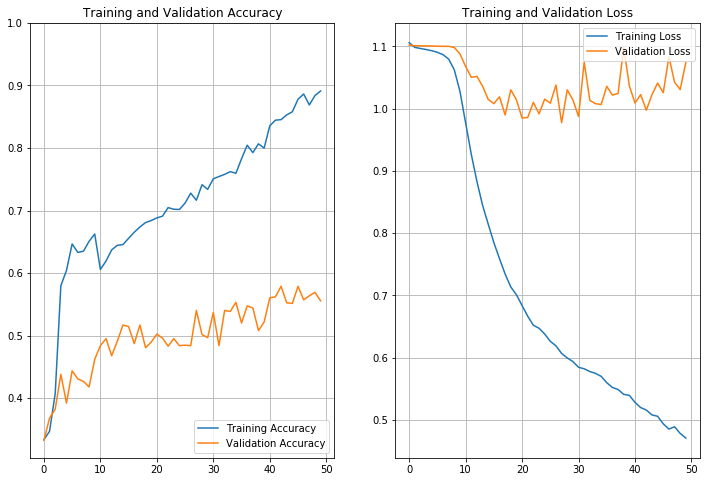

In [36]:
history= history_vgg19_2
plot_history(history,'acc','val_acc',EPOCHS)

In [37]:
EPOCHS = 30
history_vgg19_2 = model_vgg19_2.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=val_generator)

Train for 156 steps, validate for 39 steps
Epoch 1/30
156/156 [==============================] - 130s 831ms/step - loss: 0.4660 - acc: 0.8880 - val_loss: 1.0396 - val_acc: 0.5765
Epoch 2/30
156/156 [==============================] - 147s 940ms/step - loss: 0.4651 - acc: 0.8908 - val_loss: 1.0688 - val_acc: 0.5709
Epoch 3/30
156/156 [==============================] - 151s 966ms/step - loss: 0.4493 - acc: 0.9091 - val_loss: 1.0166 - val_acc: 0.5894
Epoch 4/30
156/156 [==============================] - 141s 903ms/step - loss: 0.4408 - acc: 0.9165 - val_loss: 1.0140 - val_acc: 0.5821
Epoch 5/30
156/156 [==============================] - 137s 877ms/step - loss: 0.4280 - acc: 0.9266 - val_loss: 1.0431 - val_acc: 0.5733
Epoch 6/30
156/156 [==============================] - 133s 855ms/step - loss: 0.4190 - acc: 0.9318 - val_loss: 1.0817 - val_acc: 0.5725
Epoch 7/30
156/156 [==============================] - 132s 849ms/step - loss: 0.4197 - acc: 0.9266 - val_loss: 1.1434 - val_acc: 0.5636
Epoch

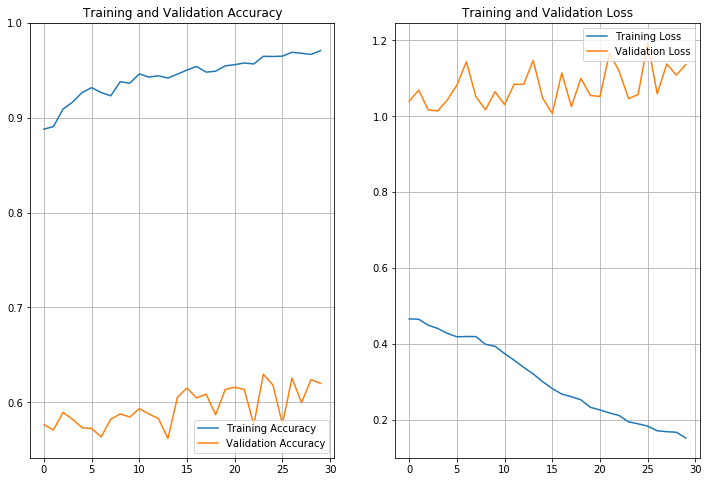

In [38]:
history= history_vgg19_2
plot_history(history,'acc','val_acc',EPOCHS)

In [39]:
EPOCHS = 50
history_vgg19_2 = model_vgg19_2.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=val_generator)

Train for 156 steps, validate for 39 steps
Epoch 1/50
156/156 [==============================] - 140s 896ms/step - loss: 0.1480 - acc: 0.9730 - val_loss: 1.0887 - val_acc: 0.6264
Epoch 2/50
156/156 [==============================] - 149s 952ms/step - loss: 0.1474 - acc: 0.9738 - val_loss: 1.2582 - val_acc: 0.5813
Epoch 3/50
156/156 [==============================] - 141s 904ms/step - loss: 0.1445 - acc: 0.9714 - val_loss: 1.0875 - val_acc: 0.6111
Epoch 4/50
156/156 [==============================] - 138s 884ms/step - loss: 0.1394 - acc: 0.9755 - val_loss: 1.1250 - val_acc: 0.6143
Epoch 5/50
156/156 [==============================] - 135s 867ms/step - loss: 0.1409 - acc: 0.9732 - val_loss: 1.1899 - val_acc: 0.6159
Epoch 6/50
156/156 [==============================] - 132s 843ms/step - loss: 0.1346 - acc: 0.9743 - val_loss: 1.0845 - val_acc: 0.6361
Epoch 7/50
156/156 [==============================] - 130s 833ms/step - loss: 0.1219 - acc: 0.9787 - val_loss: 1.0824 - val_acc: 0.6176
Epoch

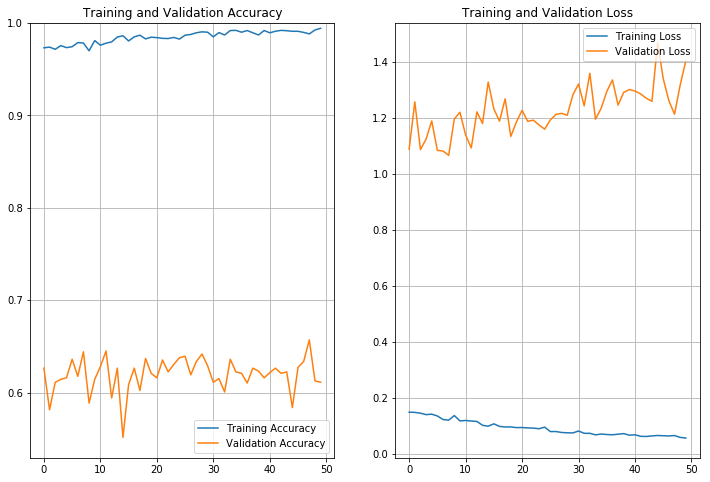

In [40]:
history= history_vgg19_2
plot_history(history,'acc','val_acc',EPOCHS)

In [41]:
model_vgg19_3=build_model_vgg19_2()
model_vgg19_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 64)          294976    
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 20,321,539
Trainable params: 297,155
Non-trainable params: 20,024,384
_________________________________________________________________


In [42]:
EPOCHS = 250
history_vgg19_3 = model_vgg19_3.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=val_generator)

Train for 156 steps, validate for 39 steps
Epoch 1/250
156/156 [==============================] - 99s 636ms/step - loss: 1.1070 - acc: 0.3333 - val_loss: 1.1012 - val_acc: 0.3333
Epoch 2/250
156/156 [==============================] - 109s 697ms/step - loss: 1.0999 - acc: 0.3390 - val_loss: 1.1002 - val_acc: 0.3736
Epoch 3/250
156/156 [==============================] - 119s 762ms/step - loss: 1.0991 - acc: 0.4037 - val_loss: 1.1001 - val_acc: 0.3816
Epoch 4/250
156/156 [==============================] - 140s 899ms/step - loss: 1.0985 - acc: 0.4965 - val_loss: 1.1001 - val_acc: 0.3857
Epoch 5/250
156/156 [==============================] - 149s 952ms/step - loss: 1.0977 - acc: 0.5667 - val_loss: 1.1001 - val_acc: 0.3905
Epoch 6/250
156/156 [==============================] - 150s 964ms/step - loss: 1.0968 - acc: 0.5518 - val_loss: 1.0999 - val_acc: 0.4090
Epoch 7/250
156/156 [==============================] - 143s 915ms/step - loss: 1.0957 - acc: 0.6411 - val_loss: 1.0997 - val_acc: 0.3929

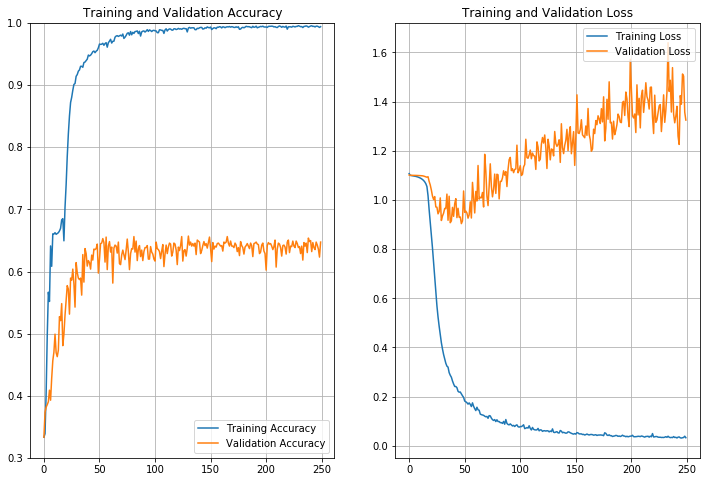

In [43]:
history= history_vgg19_3
plot_history(history,'acc','val_acc',EPOCHS)

In [44]:
# Export the model to a SavedModel
model_vgg19_3.save('/data/cmpe256-01-su2020/blaze_sight/models/pranjay/model_vgg19_3', save_format='tf')


INFO:tensorflow:Assets written to: /data/cmpe256-01-su2020/blaze_sight/models/pranjay/model_vgg19_3/assets


In [48]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.regularizers import l1

numclasses=train_generator.num_classes

def build_model_vgg19_4():
    
    IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

    # Create the base model from the pre-trained model VGG19 V2
    base_model = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Conv2D(64, 3, activation='relu',activity_regularizer=l1(0.001)))
    #model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu',activity_regularizer=l1(0.001)))
    model.add(layers.Dense(16, activation='relu',activity_regularizer=l1(0.001)))
    model.add(layers.Dense(numclasses, activation='softmax'))

    loss = losses.categorical_crossentropy#losses.sparse_categorical_crossentropy
  #one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1] But if your Yi's are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: [1] , [2], [3]
    optimizer = optimizers.SGD(lr=0.001, momentum=0.9)#optimizers.RMSprop(lr=1e-4)#optimizers.SGD(lr=0.001) #Adam(lr=0.001)
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['acc'])

    return model

In [49]:
model_vgg19_4=build_model_vgg19_4()
model_vgg19_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 64)          294976    
_________________________________________________________________
global_average_pooling2d_5 ( (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 3)                

In [50]:
EPOCHS = 50
history_vgg19_4 = model_vgg19_4.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=val_generator)

Train for 156 steps, validate for 39 steps
Epoch 1/50
156/156 [==============================] - 102s 655ms/step - loss: 1.0509 - acc: 0.4725 - val_loss: 1.0495 - val_acc: 0.5403
Epoch 2/50
156/156 [==============================] - 117s 747ms/step - loss: 0.8569 - acc: 0.6608 - val_loss: 1.0013 - val_acc: 0.5564
Epoch 3/50
156/156 [==============================] - 135s 865ms/step - loss: 0.6660 - acc: 0.7548 - val_loss: 0.9937 - val_acc: 0.5684
Epoch 4/50
156/156 [==============================] - 135s 867ms/step - loss: 0.5672 - acc: 0.7990 - val_loss: 1.1603 - val_acc: 0.4533
Epoch 5/50
156/156 [==============================] - 135s 864ms/step - loss: 0.4947 - acc: 0.8258 - val_loss: 0.9235 - val_acc: 0.5982
Epoch 6/50
156/156 [==============================] - 135s 868ms/step - loss: 0.4275 - acc: 0.8564 - val_loss: 0.9355 - val_acc: 0.5910
Epoch 7/50
156/156 [==============================] - 137s 876ms/step - loss: 0.3979 - acc: 0.8604 - val_loss: 0.8892 - val_acc: 0.6111
Epoch

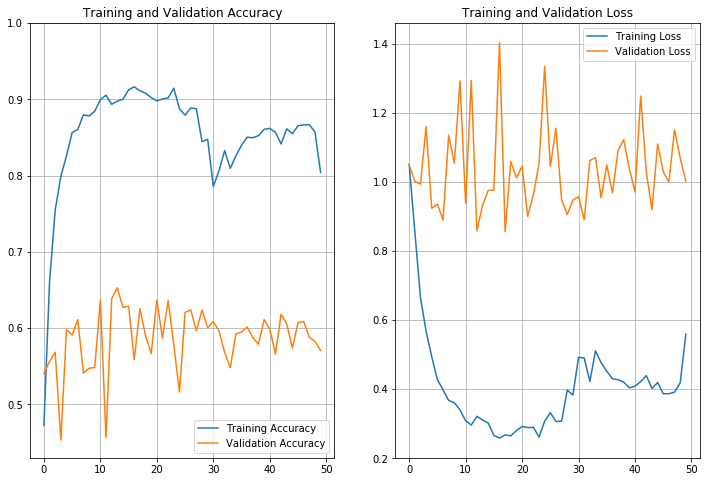

In [51]:
history= history_vgg19_4
plot_history(history,'acc','val_acc',EPOCHS)

In [52]:
# Export the model to a SavedModel
model_vgg19_4.save('/data/cmpe256-01-su2020/blaze_sight/models/pranjay/model_vgg19_4', save_format='tf')


INFO:tensorflow:Assets written to: /data/cmpe256-01-su2020/blaze_sight/models/pranjay/model_vgg19_4/assets


# On comparison I found model 1 i.e model_vgg19 as the optimum on basis of classwise accuracy compared using comparsion file